# Hybrid DOA MODEL:
1. Hybrid array modeling
2. swinging pole modeling
3. DOA algorithm - H-Music
4. EKF algorithm
5. Test banch

# Imports

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import firwin, lfilter
#from scipy.io import loadmat
from scipy.interpolate import CubicSpline
from scipy.io import savemat
import os
import re
from sklearn.metrics import root_mean_squared_error
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from collections import deque
from tqdm.notebook import tqdm


# Phased array model


## Hybrid phased array class
Mimics the behaviour of an hybris phased array built in sub arrays architecture

In [59]:
class HybridPhasedArray:
    def __init__(self, ant_per_sub, rf_num, dist_between_ant, wave_lambda,number_of_bits=8):
        self.mAntPerSubArray = ant_per_sub
        self.mAntNum = ant_per_sub * rf_num
        self.mRfNun = rf_num
        self.mDistBetweenAnt = dist_between_ant
        self.mLambda = wave_lambda
        self.mWrf = None
        self.mConfigDone = False
        self.mNumberOfBits = number_of_bits

    def Config(self, w_rf):
        self.mWrf = w_rf
        if self.mWrf.shape != (self.mRfNun, self.mAntNum):
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Hybrid phasedArray - Config first!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()
        self.mConfigDone = True

    def GetSamples(self, signal, theta):
        if not self.mConfigDone:
          print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
          print("Hybrid phasedArray - Config first!")
          print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
          exit()
        theta = np.deg2rad(theta)
        steeringVector = np.exp(2j * np.pi * np.sin(theta) * np.arange(self.mAntNum)[:, None] * self.mDistBetweenAnt / self.mLambda)
        antenna_outputs = steeringVector @ signal[np.newaxis, :]  # signal is (T,), so result is (N, T)
        received = self.mWrf @ antenna_outputs
        return received

    def GeneratePhase(self):
      numberOfPresentation= 2**(self.mNumberOfBits)
      radResolution= (2*np.pi)/numberOfPresentation
      # All possible discrete phase values
      possibolePresentation = np.array([radResolution * i for i in range(numberOfPresentation)])

      # Randomly choose phases uniformly for each antenna
      subArrayPhaseVec = np.random.choice(possibolePresentation, size=self.mAntPerSubArray, replace=True)

      # Gaussian noise vector
      noise = np.random.normal(loc=0, scale=radResolution/2, size=self.mAntPerSubArray)

      # Add noise to the chosen phases
      noisy_phases = subArrayPhaseVec + noise

      # Complex representation
      complex_phases = np.exp(1j * subArrayPhaseVec)
      complex_noisy_phases = np.exp(1j * noisy_phases)
      return complex_noisy_phases, complex_phases


## Coveriance matrix calculation class
class that build coveriance matrix out of input sampels

In [60]:
class RCalculator:
    def __init__(self, antenna_number, mode, alpha = 0.5):
        self.mAntNum = antenna_number
        self.mR = np.zeros((self.mAntNum, self.mAntNum))
        self.mAlpha = alpha
        self.mMode = mode
        if mode == "alpha filter":
          if self.mAlpha > 1 or self.mAlpha < 0:
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("R calculator - Alpha must be less then 1 and more then 0 !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()
        elif mode != "avarage":
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("R calculator - mode is not valid -> choose alpha filter or avarage !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()

    def GetSamples(self, inMatrix):
        if self.mMode == "alpha filter":
          for i in range(inMatrix.shape[1]):
              lastSampVec = inMatrix[:,i].reshape(inMatrix.shape[0], 1)
              R = lastSampVec @ lastSampVec.conj().T
              self.mR = (1 - self.mAlpha) * self.mR + self.mAlpha * R
        else:
              self.mR = np.dot(inMatrix, inMatrix.conj().T) / inMatrix.shape[1]
        return self.mR



# Pole sway class
Class that creates a movement vector according to pole sway movement model

In [61]:
class SwingingPole:

    """
    Pole sway simulator using the spectral-representation method
    Based on Hur et al. 'Millimeter Wave Beamforming for Wireless Backhaul and Access in Small Cell Networks'
    """

    def __init__(self,
                 T=100, Fs=2000, D=100,
                 u_avg=13,
                 m=5,
                 hight=10,
                 dp=0.5,
                 seed=None):

        self.T = T          # Simulation time [s]
        self.Fs = Fs        # Sampling rate [Hz]
        self.D = D          # Antennas distance [m]
        self.u_avg = u_avg  # Wind speed [m/s]
        self.rho_a = 1.22   # Air dansity [Kg/m^3]
        self.C_D = 0.5      # Drug coefficient [None]
        self.A_e = 0.09     # Affective pole area [m^2]
        self.m = m          # Pole and antenna mass [Kg]
        self.f_n = 1        # Natural pole oscilation frequency [Hz]
        self.zeta = 0.002   # Pole movement damping ratio [None]
        self.z0 = 2         # Terrain roughness [m]
        self.hight = hight  # Pole hight [m]
        self.dp = dp        # Pole diameter [m]
        self.S = 0.2        # Vortex parameter
        self.seed = seed

        self.t = None       # Time vector [s]
        self.Ld = None      # Displacement along the wind [m]
        self.Lc = None      # Displacement vertical to the wind [m]
        self.theta_d = None   # Affective misalignment angle along the win [deg]
        self.theta_c = None   # Affective misalignment angle vertical to the win [deg]

    def run(self):

        # Time and frequency grids
        N = int(self.T * self.Fs)
        dt = 1.0 / self.Fs
        t = np.arange(N) * dt
        df = self.Fs / N
        f = np.arange(N) * df

        """ Assuming wind only in the x and y directions since closness to the ground"""
        # Wind velocity field PSD - u = u_avg + Ud [d direction] + Uc [c direction]
        kappa = 0.5 * self.rho_a * self.C_D * self.A_e
        u_star = self.u_avg / (2.5 * np.log(self.hight / self.z0))
        f_vs = self.S * self.u_avg / self.dp
        Sud = (500 * u_star**2) / (np.pi * self.u_avg) * (1.0 / (1.0 + 500 * f / (2*np.pi*self.u_avg)))**(5.0/3.0)
        Suc = ( 75 * u_star**2) / (2*np.pi * self.u_avg) * (1.0 / (1.0 +  95 * f / (2*np.pi*self.u_avg)))**(5.0/3.0)

        # Applied forcs PSD
        SFd = (2 * kappa * self.u_avg)**2 * Sud
        SFc = (    kappa * self.u_avg)**2 * Suc

        """ Wind flowing torword the pole creates a vacume behind it which creating ocsilating drug force - vortex shreding"""
        # Vortex shedding PSD
        SF_vs = kappa**2 * 1.125 * np.sqrt(np.pi * np.divide(f, f_vs, out=np.zeros_like(f), where=f_vs!=0)) \
                * np.exp(-((1.0 - np.divide(f, f_vs, out=np.zeros_like(f), where=f_vs!=0))**2) / 0.18)

        # Mechanical pole transfer function
        ratio = np.divide(f, self.f_n, out=np.zeros_like(f), where=self.f_n!=0)
        Hm = 1.0 / (4.0 * self.m * np.pi**2 * self.f_n**2 *
                    np.sqrt((1 - ratio**2)**2 + (2*self.zeta*ratio)**2))
        SLd = np.abs(Hm)**2 * SFd
        SLc = np.abs(Hm)**2 * (SFc + SF_vs)

        # Finale movement PSD adding random phases
        Npos = N//2 + 1 if N % 2 == 0 else (N + 1)//2
        rng = np.random.default_rng(self.seed)
        phi1 = rng.random(Npos) * 2*np.pi
        phi2 = rng.random(Npos) * 2*np.pi
        Delta_f = self.Fs / N
        Sd_pos = (N/2.0) * np.sqrt(2.0 * SLd[:Npos] * Delta_f) * np.exp(1j * phi1)
        Sc_pos = (N/2.0) * np.sqrt(2.0 * SLc[:Npos] * Delta_f) * np.exp(1j * phi2)
        Sd_full = np.zeros(N, dtype=complex)
        Sc_full = np.zeros(N, dtype=complex)
        Sd_full[:Npos] = Sd_pos
        Sc_full[:Npos] = Sc_pos
        if N % 2 == 0:
            Sd_full[Npos:] = np.conj(Sd_pos[1:-1][::-1])
            Sc_full[Npos:] = np.conj(Sc_pos[1:-1][::-1])
        else:
            Sd_full[Npos:] = np.conj(Sd_pos[1:][::-1])
            Sc_full[Npos:] = np.conj(Sc_pos[1:][::-1])

        #Exctracing freq
        Ld_freq= f[np.argmax(SLd)]
        Lc_freq= f[np.argmax(SLc)]
        # Creating position vector using IFFT
        Ld = np.real(np.fft.ifft(Sd_full))
        Lc = np.real(np.fft.ifft(Sc_full))
        theta_d = np.degrees(np.arctan2(Ld, self.D))
        theta_c = np.degrees(np.arctan2(Lc, self.hight))
        #calculate the velocity
        velocity_d = np.zeros_like(theta_d)
        velocity_d[0] = 0
        velocity_d[1:] = (theta_d[1:] - theta_d[:-1]) / dt
        velocity_c = np.zeros_like(theta_d)
        velocity_c[0] = 0
        velocity_c[1:] = (theta_c[1:] - theta_c[:-1]) / dt

        self.t, self.Ld, self.Lc, self.theta_d, self.theta_c = t, Ld, Lc, theta_d, theta_c
        return theta_d, theta_c, Ld_freq, Lc_freq, velocity_d, velocity_c

    def plot_results(self):           # Continue - adjust to 2D
        """Plot time series and 3D sway trajectory."""
        if self.t is None or self.Ld is None:
            raise RuntimeError("Run the simulation first using .run()")

        fig = plt.figure(figsize=(12, 9))
        gs = GridSpec(3, 3, figure=fig)

        # 3D scatter
        ax3d = fig.add_subplot(gs[:, 1:], projection='3d')
        sc = ax3d.scatter(self.Lc*100.0, self.Ld*100.0, self.t, s=2, c=self.t)
        ax3d.set_title('Pole sway – $L_c(t)$ vs. $L_d(t)$')
        ax3d.set_xlabel('$L_c$ [cm]')
        ax3d.set_ylabel('$L_d$ [cm]')
        ax3d.set_zlabel('Time [s]')
        cb = fig.colorbar(sc, ax=ax3d, fraction=0.03, pad=0.08)
        cb.set_label('Time [s]')

        # Cross-wind
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(self.t, self.Lc*100.0)
        ax1.set_title('Pole sway – cross-wind $L_c(t)$')
        ax1.set_xlabel('Time [s]')
        ax1.set_ylabel('$L_c$ [cm]')

        # Along-wind
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.plot(self.t, self.Ld*100.0)
        ax2.set_title('Pole sway – along-wind $L_d(t)$')
        ax2.set_xlabel('Time [s]')
        ax2.set_ylabel('$L_d$ [cm]')

        # Tilt angle
        ax3 = fig.add_subplot(gs[2, 0])
        ax3.plot(self.t, self.theta_d)
        ax3.set_title('Tilt angle $\\theta_L(t)$')
        ax3.set_xlabel('Time [s]')
        ax3.set_ylabel('$\\theta_L$ [deg]')

        fig.suptitle('Pole sway time series', fontsize=14)
        plt.tight_layout()
        PlotItAdequate(plt)

# DOA algorithms

## Hybrid MUSIC class
Class that recieves coveriance matrix and perform H-Music DOA

In [62]:
class HMusicDoa:
    def __init__(self, ant_num,rf_num, dist_between_ant, wave_lambda, weights_matrix):
        self.mNumberOfAntennas = ant_num
        self.mNumberOfSubArrays=rf_num
        self.mDistBetweenAnt = dist_between_ant
        self.mLambda = wave_lambda
        self.mWeightsMatrix = weights_matrix
        self.mPower = None
        self.mAngles = None
        ArrayX=[]
        ArrayY=[]
        self.mArrayOfMultiplicationPerScan=[]
        self.mArrayOfMultiplicationPerScan.append(ArrayX)
        self.mArrayOfMultiplicationPerScan.append(ArrayY)

    def UpdateWRF(self, weights_matrix):
      self.mWeightsMatrix = weights_matrix
      if self.mWeightsMatrix.shape != (self.mNumberOfAntennas*self.mNumberOfSubArrays, self.mNumberOfAntennas*self.mNumberOfSubArrays):
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              print("HMusicDoa - Analog weights matrix shape is not valid !!")
              print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxX")
              exit()


    def GetSamples(self, R, dimensionNmber, scanAnglesDeg=np.arange(-90, 91, 1), signal_count=1 ):
        angles = scanAnglesDeg
        power = []
        NumberOfmultiplicationPerScan=0
        eigvals, eigvecs = np.linalg.eigh(R)
        NumberOfmultiplicationPerScan += CalcApproxEigenMulti(R.shape)
        noise_eigvecs = eigvecs[:, :-signal_count]  #vectors with the smallest eigen valuse
        for theta_deg in angles:
            theta = np.deg2rad(theta_deg)
            steering_vec_without_wight=  np.exp(2j * np.pi * self.mDistBetweenAnt * np.sin(theta) * np.arange(self.mNumberOfAntennas * self.mNumberOfSubArrays) / self.mLambda).reshape(-1, 1) #size(ant_num * num_rf,1)
            steering_vec = self.mWeightsMatrix @ steering_vec_without_wight #size(rf_num,1)
            steering_vec_norm = steering_vec / np.linalg.norm(steering_vec)
            power.append(1.0 / np.linalg.norm(np.dot(noise_eigvecs.conj().T, steering_vec_norm))**2)
            #complexity calc
            k = noise_eigvecs.shape[1]
            M= steering_vec_norm.size
            NumberOfmultiplicationPerScan += (self.mNumberOfAntennas * self.mNumberOfSubArrays*2 + #every complex multiplication needs 2 clk cycle
                                              CalcNumberOfMulti(self.mWeightsMatrix.shape,steering_vec_without_wight.shape) *2+
                                              2*steering_vec.size+ #calc the steering_vec_norm
                                              k*M+k-1 #calc the power
                                              )
        self.mArrayOfMultiplicationPerScan[dimensionNmber].append(NumberOfmultiplicationPerScan)
        power = np.abs(power)
        power /= np.max(power)
        power_db = 10 * np.log(power + 1e-6)
        self.mPower = power_db
        self.mAngles = angles
        return angles, power_db

    def PlotPower(self):
        plt.plot(self.mAngles, self.mPower)
        plt.xlabel("Theta [Degrees]")
        plt.ylabel("DOA power calculation")
        plt.grid()
        plt.show()

## Comlexity Helper functions

In [63]:
def CalcNumberOfMulti(A_shape,B_sahpe):
  return A_shape[0]*B_sahpe[1]*A_shape[1]

def CalcNumberOfAdd(A_shape,B_sahpe):
  return A_shape[0]*B_sahpe[1]*(A_shape[1]-1)

def CalcApproxEigenMulti(A_sahpe):
  return (4/3)*((A_sahpe[0])**3)

# EKF



## EKF class

Class that implement EKF with oscilator movement model



In [64]:
class EKF:
    def __init__(self, init_angle, init_angularVelocity,init_Omega, init_var, measurments_var, proccess_variance,dt):
        self.mX = np.array([[init_angle],
                            [init_angularVelocity],
                            [init_Omega]])
        self.mX_predict=None
        self.mP = np.diag(init_var)
        self.mP_predict = None
        self.mR =  np.array([[measurments_var]])
        self.mQ = np.diag(proccess_variance)
        self.mH =np.array([[1,0,0]])
        self.mI= np.eye(3)
        self.mdt=dt
        self.mArrayOfmultiplications=[]
        self.OnlyPrediction()

    def OnlyPrediction(self):
      new_theat= self.mX[0,0]+ self.mdt*self.mX[1,0]
      new_theta_dot= self.mX[1,0] - self.mdt*self.mX[0,0]*self.mX[2,0] ** 2
      new_omega = self.mX[2,0]

      F_Jacobian = np.array([[1, self.mdt,0],
                            [-(self.mX[2,0]**2) * self.mdt, 1, -2* self.mX[2,0] * self.mX[0,0] * self.mdt],
                            [0, 0, 1]])
      # --- Prediction ---
      self.mX_predict = np.array([[new_theat],
                  [new_theta_dot],
                  [new_omega]])
      self.mP_predict = F_Jacobian @ self.mP @ F_Jacobian.T + self.mQ


    def GetSampels(self, input):
        if isinstance(input, np.ndarray):
          outStateVec = []
          outVarVec = []
          for sample in input:
              if -91 < sample < 91:
                  stateVec, varianceMatrix = self.ApplyFilter(sample) #get the state vector and the variance matrix
              else:
                  stateVec, varianceMatrix = self.Override()
              outStateVec.append(stateVec.flatten())
              outVarVec.append(np.diag(varianceMatrix))
          return np.array(outStateVec), np.array(outVarVec)
        else:
          if -91 < input < 91:
              stateVec, varianceMatrix = self.ApplyFilter(input)
          else:
              stateVec, varianceMatrix = self.Override()
          return stateVec.flatten(), np.diag(varianceMatrix)

    def Override(self):
        # --- Update ---
        self.mX = self.mX_predict
        self.mP=self.mP_predict

        # --- Prediction only ---
        new_theat= self.mX[0,0]+ self.mdt*self.mX[1,0]
        new_theta_dot= self.mX[1,0] - self.mdt*self.mX[0,0]*self.mX[2,0] ** 2
        new_omega = self.mX[2,0]

        F_Jacobian = np.array([[1, self.mdt,0],
                               [-(self.mX[2,0]**2) * self.mdt, 1, -2* self.mX[2,0] * self.mX[0,0] * self.mdt],
                               [0, 0, 1]])


        self.mX_predict = np.array([[new_theat],
                    [new_theta_dot],
                    [new_omega]])
        self.mP_predict = F_Jacobian @ self.mP @ F_Jacobian.T + self.mQ


        return self.mX, self.mP


    def ApplyFilter(self, measuredPos):

        # ==== Update ====

        #Kalman Gain Update
        K= self.mP_predict @ self.mH.T @ np.linalg.inv( self.mH @ self.mP_predict @ self.mH.T+ self.mR)
        #State Update
        z = np.array([[measuredPos]])
        self.mX= self.mX_predict + K @ (z-self.mH@ self.mX_predict)
        #Variance Update
        helperFor_mP_calc= (self.mI - K @ self.mH)
        self.mP = helperFor_mP_calc @ self.mP_predict @ helperFor_mP_calc.T + K @ self.mR @ K.T

        # ==== Prediction ====
        #calculate f(x_(n,n)) because it is not linear and we can not write it as a matrix
        new_theat= self.mX[0,0]+ self.mdt*self.mX[1,0]
        new_theta_dot= self.mX[1,0] - self.mdt*self.mX[0,0]*self.mX[2,0] ** 2
        new_omega = self.mX[2,0]
        #Jacobian
        F_Jacobian = np.array([[1, self.mdt,0],
                               [-(self.mX[2,0]**2) * self.mdt, 1, -2* self.mX[2,0] * self.mX[0,0] * self.mdt],
                               [0, 0, 1]])
        #predict
        self.mX_predict = np.array([[new_theat],
                    [new_theta_dot],
                    [new_omega]])
        self.mP_predict = F_Jacobian @ self.mP @ F_Jacobian.T + self.mQ

        # ==== Complexity ====
        multNum =(9+ #the first build
                  54+ #Prediction
                  24+ #Kalman Update
                  6+ #update mX
                  36 #update mP
                  )
        self.mArrayOfmultiplications.append(multNum)

        return self.mX, self.mP



# Support classes

### Peaks finder class

In [65]:
class PeaksFinder:

    def __init__(self, peaks_num):
        self.mPeaksNum = peaks_num
        if self.mPeaksNum < 1:
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            print("Peaks finder - Enter at least one peak to find !!!")
            print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
            exit()

    def GetSamples(self, power_values, scanAnglesDeg):
        peaksIdx = find_peaks(np.squeeze(power_values))[0]
        if len(peaksIdx) == 0:
            print("000000000000000000000000000000000000000000")
            print("Peaks finder - No maximum points found !!!")
            print("000000000000000000000000000000000000000000")
        if self.mPeaksNum > len(peaksIdx):
            print("000000000000000000000000000000000000000000000000000")
            print("Peaks finder - Didnt found anoth maximum points !!!")
            print("000000000000000000000000000000000000000000000000000")
        peaksPowers = power_values[peaksIdx]
        sortedIndices = np.argsort(peaksPowers)[::-1]
        topPeaksIdx = peaksIdx[sortedIndices[:self.mPeaksNum]]
        topAngles = scanAnglesDeg[topPeaksIdx.tolist()]

        # ~~~~ If error - return -200 (for kalmans override) ~~~~ #
        if len(topAngles) < self.mPeaksNum:
            topAngles = list(topAngles) + [-200] * (self.mPeaksNum - len(topAngles))
        if self.mPeaksNum == 1:
            return topAngles[0]
        else:
            return topAngles

## For Matlab


In [66]:

def ExportSimulationToMat(filepath, data):
    """
    Export all relevant simulation data (only selected plots) to a MATLAB .mat file.

    Parameters:
    -----------
    filepath : str
        Path where the .mat file will be saved
    data : list of dicts
        List where each element is a dictionary containing data for one dimension
    """

    # CHANGED: Convert list to dictionary format required by savemat
    # Transform data[0], data[1], ... into {"dim_0": {...}, "dim_1": {...}, ...}
    mat_dict = {}
    for i, dim_data in enumerate(data):
        dim_key = f"dim_{i}"
        mat_dict[dim_key] = dim_data

    # ----------------------------------------------------------------------
    # SAVE THE FILE
    # ----------------------------------------------------------------------
    savemat(filepath, mat_dict)
    print(f"Saved MATLAB file: {filepath}")

def ExportComplexityToMat(dataToExport,
                          number_of_dimensions,
                          fileName):
    matlab_data = {}
    for i in range(number_of_dimensions):
        x1=dataToExport[i][0]
        x2=dataToExport[i][1]
        y1=dataToExport[i][2]
        y2=dataToExport[i][3]
        matlab_data[f'dim_{i+1}_x1'] = x1
        matlab_data[f'dim_{i+1}_y1'] = y1
        matlab_data[f'dim_{i+1}_x2'] = x2
        matlab_data[f'dim_{i+1}_y2'] = y2
    savemat(f"/content/Simulation/Complexity/{fileName}.mat", matlab_data)

def ExportTimeAnalsysToMat(dataToExport,
                          number_of_dimensions,
                          fileName):
    matlab_data = {}
    for i in range(number_of_dimensions):
        coherence_time_step=dataToExport[i][0]
        calculation_time_without_kalman_step=dataToExport[i][1]
        calculation_time_with_kalman_step=dataToExport[i][2]
        coherence_time_value=dataToExport[i][3]
        calculation_time_without_kalman_value=dataToExport[i][4]
        calculation_time_with_kalman_value=dataToExport[i][5]
        matlab_data[f'dim_{i+1}_coherence_time_step'] = coherence_time_step
        matlab_data[f'dim_{i+1}_calculation_time_without_kalman_step'] = calculation_time_without_kalman_step
        matlab_data[f'dim_{i+1}_calculation_time_with_kalman_step'] = calculation_time_with_kalman_step
        matlab_data[f'dim_{i+1}_coherence_time_value'] = coherence_time_value
        matlab_data[f'dim_{i+1}_calculation_time_without_kalman_value'] = calculation_time_without_kalman_value
        matlab_data[f'dim_{i+1}_calculation_time_with_kalman_value'] = calculation_time_with_kalman_value
    savemat(f"/content/Simulation/Complexity/{fileName}.mat", matlab_data)

def Exportrmse_Vs_X(X_vec, rmse_vs_sweep, measurments_var_vec, output_file):

    num_meas_vars = len(measurments_var_vec)
    num_dims = len(rmse_vs_sweep[0][0][0])

    matlab_struct = []

    for dim in range(num_dims):

        # Pack MATLAB struct for this dimension
        entry = {}

        # store X
        entry["X"] = np.array(X_vec)

        # store before Kalman rmse
        entry["rmse_before"] = np.array(
            [rmse_vs_sweep[0][0][p][dim] for p in range(len(X_vec))]
        )

        # store all after-Kalman curves
        entry["rmse_after"] = np.array([
            [rmse_vs_sweep[1][m][p][dim] for p in range(len(X_vec))]
            for m in range(num_meas_vars)
        ])

        # store variances so MATLAB can interpret which curve belongs to which variance
        entry["variance"] = np.array(measurments_var_vec)

        matlab_struct.append(entry)

    savemat(f"/content/Simulation/rmse_Vs_X/{output_file}.mat", {"rmsedata": matlab_struct})

def ExportPoleSway(theta_d,theta_c):
      dataOfPoleSway={}
      dataOfPoleSway['theta_d']=theta_d
      dataOfPoleSway['theta_c']=theta_c
      dataOfPoleSway['time']=pole.t
      savemat(f"/content/Simulation/PoleSway/PoleSway.mat", dataOfPoleSway)
def Exportr_LinkOutage(dataToExport, measurments_var_vec, X_vec, output_file):
    """
    Export link outage data to MATLAB .mat file

    Parameters:
    - dataToExport: [before_kalman_list, after_kalman_list]
    - measurments_var_vec: vector of measurement variances
    - X_vec: vector of parameter values (e.g., SNR values)
    - output_file: output filename (without .mat extension)
    """

    params_length = len(X_vec)
    num_configs = len(measurments_var_vec) * params_length

    # Calculate success ratios for each configuration
    ratios_before = []
    ratios_after = []

    for i in range(len(dataToExport[0])):
        # Before Kalman: calculate mean (ratio of failures)
        before_data = np.array(dataToExport[0][i])
        if before_data.size > 0:
            ratios_before.append(np.mean(before_data))
        else:
            ratios_before.append(0)

        # After Kalman: calculate mean (ratio of failures)
        after_data = np.array(dataToExport[1][i])
        if after_data.size > 0:
            ratios_after.append(np.mean(after_data))
        else:
            ratios_after.append(0)

    # Prepare data structures for MATLAB
    matlab_data = {
        'measurments_var_vec': np.array(measurments_var_vec),
        'X_vec': np.array(X_vec),
        'params_length': params_length,
        'num_measurements': len(measurments_var_vec),
        'num_configs': num_configs,
        'ratios_before_kalman': np.array(ratios_before),
        'ratios_after_kalman': np.array(ratios_after)
    }

    # Add raw time series data as well (for other analyses if needed)
    matlab_data['before_kalman'] = dataToExport[0]
    matlab_data['after_kalman'] = dataToExport[1]

    # Create configuration mapping
    m_indices = []
    x_indices = []
    var_values = []
    X_param_values = []

    for m in range(len(measurments_var_vec)):
        for x in range(len(X_vec)):
            m_indices.append(m)
            x_indices.append(x)
            var_values.append(measurments_var_vec[m])
            X_param_values.append(X_vec[x])

    matlab_data['m_indices'] = np.array(m_indices)
    matlab_data['x_indices'] = np.array(x_indices)
    matlab_data['var_values'] = np.array(var_values)
    matlab_data['X_param_values'] = np.array(X_param_values)

    # Save to .mat file
    output_path = f"/content/Simulation/LinkOutage/{output_file}_{theta_max}.mat"
    savemat(output_path, matlab_data)

    print(f"Data exported successfully to: {output_path}")
    print(f"Total configurations: {num_configs}")
    print(f"Number of measurement variances: {len(measurments_var_vec)}")
    print(f"Number of X parameters: {len(X_vec)}")

## Plot functions

In [67]:
!rm -rf /content/Simulation
!mkdir /content/Simulation
!mkdir /content/Simulation/Complexity
!mkdir /content/Simulation/Visualization
!mkdir /content/Simulation/rmse_Vs_X
!mkdir /content/Simulation/PoleSway
!mkdir /content/Simulation/LinkOutage

def PlotItAdequate(
        plt,
        save_folder="/content/Simulation",
        axis_linewidth=2,
        tick_width=2,
        label_fontsize=28,
        tick_fontsize=22,
        title_fontsize=20,
        suptitle_fontsize=20,
        legend_fontsize=20,
        grid_alpha=0.3,
        save_png=True,
        save_eps=True):

    fig = plt.gcf()
    axes = fig.get_axes()

    # -------- Get suptitle or axis title for filename ----------
    suptitle_obj = fig._suptitle
    main_title = suptitle_obj.get_text() if suptitle_obj else None

    if not main_title:
        for ax in axes:
            if ax.get_title():
                main_title = ax.get_title()
                break

    if not main_title:
        main_title = "figure"

    # Sanitize file name
    filename_base = re.sub(r"[^A-Za-z0-9_-]", "_", main_title)
    png_path = os.path.join(save_folder, filename_base + ".png")
    eps_path = os.path.join(save_folder, filename_base + ".eps")

    # -------- Format Axes ----------
    for ax in axes:
        # Thicker spines
        for spine in ax.spines.values():
            spine.set_linewidth(axis_linewidth)

        # Tick settings
        ax.tick_params(width=tick_width, length=6,
                       labelsize=tick_fontsize, direction="in",
                       top=True, right=True, labeltop=False, labelright=False)

        # Labels
        ax.xaxis.label.set_size(label_fontsize)
        ax.yaxis.label.set_size(label_fontsize)

        # Grid
        ax.grid(True, linestyle="--", linewidth=0.8, alpha=grid_alpha)
        leg = ax.get_legend()
        if leg:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(
                handles, labels,
                loc='lower center',
                bbox_to_anchor=(0.5, 1.08),
                ncol=2,
                fontsize=legend_fontsize,
                frameon=True,
                edgecolor='black',
                facecolor='white',
                framealpha=0.95,
                borderaxespad=0
            )

            # Makes the legend with pointy corners
            leg = ax.get_legend()
            frame = leg.get_frame()
            frame.set_boxstyle("square")

        # Title formatting
        ax.title.set_size(title_fontsize)
        ax.title.set_weight("bold")

    # Suptitle formatting
    if suptitle_obj:
        suptitle_obj.set_size(suptitle_fontsize)
        suptitle_obj.set_weight("bold")

    # Layout: leave space at top for legends, tight elsewhere
    fig.subplots_adjust(left=0.10, right=0.95, top=0.75, bottom=0.12, wspace=0.25)

    # -------- Remove titles before saving --------
    stored_suptitle = suptitle_obj.get_text() if suptitle_obj else None
    stored_titles = [ax.get_title() for ax in axes]

    if suptitle_obj:
        suptitle_obj.set_text("")

    for ax in axes:
        ax.set_title("")

    # Save
    if save_png:
        plt.savefig(png_path, dpi=600)

    if save_eps:
        plt.savefig(eps_path, dpi=600, format="eps")

    # -------- Restore titles after saving --------
    if suptitle_obj:
        suptitle_obj.set_text(stored_suptitle)

    for ax, t in zip(axes, stored_titles):
        ax.set_title(t)


def PlotSimulation(state_variance_plot,
                   number_of_dimensions,
                   Titel,
                   pole_movement_vec,
                   est_angles_before_kalman_vec,
                   est_angles_after_kalman_vec,
                   est_angles_velocities_kalman_vec,
                   est_omega_after_kalman_vec,
                   ciPosition,
                   ciVelocity,
                   ciOmega,
                   rmse_before_vec,
                   rmse_after_vec,
                   ant_per_sub_array):


    # --- Count required subplots ---
    to_plot_indices = [i for i, (plot_val, plot_var) in enumerate(state_variance_plot) if plot_val]
    n_plots = len(to_plot_indices)

    fig, axes = plt.subplots(n_plots, number_of_dimensions, figsize=(20, 6 * n_plots))
    axes = axes.flatten()
    counter = 0
    dataToExport = [[] for _ in range(number_of_dimensions)]
        # CHANGED: Initialize dataperDim for each dimension
    for j in range(number_of_dimensions):
        dataToExport[j] = {}
        dataToExport[j]["time"] = pole.t[ant_per_sub_array - 1:]
        dataToExport[j]["true_position"] = None
        dataToExport[j]["DOA_position"] = None
        dataToExport[j]["Kalman_position"] = None
        dataToExport[j]["Kalman_position_ci"] = None
        dataToExport[j]["true_velocity"] = None
        dataToExport[j]["kalman_velocity"] = None
        dataToExport[j]["kalman_velocity_ci"] = None
        dataToExport[j]["true_omega"] = None
        dataToExport[j]["kalman_omega"] = None
        dataToExport[j]["kalman_omega_ci"] = None
    # ===========================
    #      POSITION (i == 0)
    # ===========================
    for i, (plot_value, plot_variance) in enumerate(state_variance_plot):

        if i == 0 and plot_value:
            for j in range(number_of_dimensions):
                ax = axes[counter]; counter += 1

                ax.plot(pole_movement_vec[j][ant_per_sub_array - 1:], label="True angle", color='blue')
                ax.plot(est_angles_before_kalman_vec[j],
                        label="Before Kalman (H-MUSIC)", color='green')
                ax.plot(est_angles_after_kalman_vec[j],
                        label="After Kalman", color='orange')

                # Axis labels
                ax.set_xlabel("Sample index")
                ax.set_ylabel("Angle (degrees)")
                ax.set_title(Titel[j])
                ax.grid(True)
                ax.legend(loc='upper right')
                #-------export data-------
                dataToExport[j]["true_position"] = pole_movement_vec[j][ant_per_sub_array - 1:]
                dataToExport[j]["DOA_position"] = est_angles_before_kalman_vec[j]
                dataToExport[j]["Kalman_position"] = est_angles_after_kalman_vec[j]


                # CI in *orange* (Kalman color)
                if plot_variance:
                    dataToExport[j]["Kalman_position_ci"] = ciPosition[j]
                    ax.fill_between(
                        np.arange(len(est_angles_after_kalman_vec[j])),
                        est_angles_after_kalman_vec[j] - ciPosition[j],
                        est_angles_after_kalman_vec[j] + ciPosition[j],
                        color='orange', alpha=0.25,
                        label='95% CI'
                    )

        # ===========================
        #     VELOCITY (i == 1)
        # ===========================
        elif i == 1 and plot_value:
            for j in range(number_of_dimensions):
                ax = axes[counter]; counter += 1

                ax.plot(pole_movement_vec[j+4][ant_per_sub_array - 1:], label="True velocity", color='blue')
                ax.plot(est_angles_velocities_kalman_vec[j],
                        label="Velocity after Kalman", color='orange')

                ax.set_xlabel("Sample index")
                ax.set_ylabel("Velocity (deg/sec)")
                ax.set_title(Titel[j+2])
                ax.grid(True)
                ax.legend(loc='upper right')

                #-----export data------
                dataToExport[j]["true_velocity"] = pole_movement_vec[j+4][ant_per_sub_array - 1:]
                dataToExport[j]["kalman_velocity"] = est_angles_velocities_kalman_vec[j]

                if plot_variance:
                    dataToExport[j]["kalman_velocity_ci"] = ciVelocity[j]
                    ax.fill_between(
                        np.arange(len(est_angles_velocities_kalman_vec[j])),
                        est_angles_velocities_kalman_vec[j] - ciVelocity[j],
                        est_angles_velocities_kalman_vec[j] + ciVelocity[j],
                        color='orange', alpha=0.25
                    )

        # ===========================
        #      OMEGA (i == 2)
        # ===========================
        elif i == 2 and plot_value:
            for j in range(number_of_dimensions):
                ax = axes[counter]; counter += 1



                omega_true = np.ones_like(est_omega_after_kalman_vec[j]) * pole_movement_vec[j+2] * 2 * np.pi

                ax.plot(omega_true, label="True omega", color='blue')
                ax.plot(est_omega_after_kalman_vec[j],
                        label="Omega after Kalman", color='orange')

                ax.set_xlabel("Sample index")
                ax.set_ylabel("Omega (rad/sec)")
                ax.set_title(Titel[j+4])
                ax.grid(True)
                ax.legend(loc='upper right')

                #------export data----
                dataToExport[j]["true_omega"] = omega_true
                dataToExport[j]["kalman_omega"] = est_omega_after_kalman_vec[j]

                if plot_variance:
                    dataToExport[j]["kalman_omega_ci"] = ciOmega[j]
                    ax.fill_between(
                        np.arange(len(est_omega_after_kalman_vec[j])),
                        est_omega_after_kalman_vec[j] - ciOmega[j],
                        est_omega_after_kalman_vec[j] + ciOmega[j],
                        color='orange', alpha=0.25
                    )

    # ----- Supertitle -----
    subtitle_string = (
      f"SNR = {snr} dB, R Frequency = {R_creating_freq}, Samples per R = {samples_for_R_calc}"
      f" {Titel[0]} rmse: Before={rmse_before_vec[0]:.4f}, After={rmse_after_vec[0]:.4f}  |"
      f" {Titel[1]} rmse: Before={rmse_before_vec[1]:.4f}, After={rmse_after_vec[1]:.4f}"
      )
    fig.suptitle(
        f"SNR = {snr} dB, R Frequency = {R_creating_freq}, Samples per R = {samples_for_R_calc}\n"
        f"{Titel[0]} rmse: Before={rmse_before_vec[0]:.4f}, After={rmse_after_vec[0]:.4f}   |   "
        f"{Titel[1]} rmse: Before={rmse_before_vec[1]:.4f}, After={rmse_after_vec[1]:.4f}",
        fontsize=40,
        fontweight='bold'
    )

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    filepath=f"/content/Simulation/Visualization/{subtitle_string}.mat"

    ExportSimulationToMat(filepath, dataToExport)
    plt.show()

def PlotNumberOfMultiplications(hmusic_without_kalman,
                                hmusic_with_kalman,
                                kalman_vec,
                                number_of_dimensions,
                                Title):
  fig, axes = plt.subplots(1, number_of_dimensions, figsize=(16, 10))
  axes = axes.flatten()
  dataToExport = [[] for _ in range(number_of_dimensions)]
  for i in range(number_of_dimensions):
    y1=np.array(hmusic_without_kalman.mArrayOfMultiplicationPerScan[i])
    x1=np.arange(len(y1))
    y2=np.array(hmusic_with_kalman.mArrayOfMultiplicationPerScan[i])+ np.array(kalman_vec[i].mArrayOfmultiplications)
    x2=np.arange(len(y2))
    dataToExport[i].extend([x1, x2, y1, y2])
    axes[i].plot(x1, y1, label=f'Only H-Music with resolution of {Title[0]}')
    axes[i].plot(x2, y2, label=f'H-Music with Kalman with resolution of {Title[1]}')
    axes[i].set_xlabel('Scan')
    axes[i].set_ylabel('Number of multiplications')
    axes[i].set_title('Number of mult per Scan')
    axes[i].grid(True)
    axes[i].legend()
  ExportComplexityToMat(dataToExport,
                        number_of_dimensions,
                        f"NumberOfMultiplications_NoKalman_{Title[0]}_withKalman_{Title[1]}")
  #PlotItAdequate(plt)
  plt.show()

def PlotMultiplacationTimePerSample(samples_for_R_calc,
                                    hmusic_without_kalman,
                                    hmusic_with_kalman,
                                    kalman_vec,
                                    number_of_dimensions):
  fig, axes = plt.subplots(1, number_of_dimensions, figsize=(16, 10))
  axes = axes.flatten()
  dataToExport = [[] for _ in range(number_of_dimensions)]
  for i in range(number_of_dimensions):
    #coherence time
    coherence_time_value = np.ones(len(hmusic_with_kalman.mArrayOfMultiplicationPerScan[i])) * 0.01  # seconds
    coherence_time_step=np.arange(len(coherence_time_value))
    #calculation time without kalman
    calculation_time_without_kalman_value=(
            np.array(hmusic_without_kalman.mArrayOfMultiplicationPerScan[i]) * 2.21e-9 +    # FPGA multiplications for H-music
            np.ones(len(coherence_time_value)) * (samples_for_R_calc * 1e-9) +              # sampling time for creating R
            np.ones(len(coherence_time_value)) * 500e-9                                     # phase shifter update
        )
    calculation_time_without_kalman_step=np.arange(len(calculation_time_without_kalman_value))
    #calculation time with kalman
    calculation_time_with_kalman_value = (
            np.array(hmusic_with_kalman.mArrayOfMultiplicationPerScan[i]) * 2.21e-9 +   # FPGA multiplications for H-music
            np.array(kalman_vec[i].mArrayOfmultiplications) * 2.21e-9 +                 # FPGA multiplications for Kalman filter
            np.ones(len(coherence_time_value)) * (samples_for_R_calc * 1e-9) +          # sampling time for creating R
            np.ones(len(coherence_time_value)) * 500e-9                                 # phase shifter update
        )
    calculation_time_with_kalman_step=np.arange(len(calculation_time_with_kalman_value))
    #plot and export
    ymax = 10
    dataToExport[i].extend([coherence_time_step, calculation_time_without_kalman_step,calculation_time_with_kalman_step , coherence_time_value, calculation_time_without_kalman_value,calculation_time_with_kalman_value])

    axes[i].plot(coherence_time_step, coherence_time_value*1e3, label=f'coherence time limit')
    axes[i].set_yticks(np.arange(1, ymax+1, 1))
    axes[i].plot(calculation_time_without_kalman_step, calculation_time_without_kalman_value*1e3, label=f'time for estimation the angle without kalman')
    axes[i].plot(calculation_time_with_kalman_step, calculation_time_with_kalman_value*1e3, label=f'time for estimation the angle with kalman')
    axes[i].set_xlabel('Scan')
    axes[i].set_ylabel('Milliseconds [ms]')
    axes[i].set_title('Coherence time')
    axes[i].grid(True)
    axes[i].legend()
  ExportTimeAnalsysToMat(dataToExport,
                        number_of_dimensions,
                        f"MultiplacationTimePerSample_res_{angle_res}")
  #PlotItAdequate(plt)
  plt.show()

def PlotMultiplacationTimePerSample_Delta(samples_for_R_calc,
                                    hmusic_with_kalman,
                                    kalman_vec,
                                    number_of_dimensions):
  fig, axes = plt.subplots(1, number_of_dimensions, figsize=(16, 10))
  axes = axes.flatten()
  for i in range(number_of_dimensions):
    y1 = np.ones(len(hmusic_with_kalman.mArrayOfMultiplicationPerScan[i])) * 0.01  # seconds
    x1=np.arange(len(y1))
    y2 = (
            np.array(hmusic_with_kalman.mArrayOfMultiplicationPerScan[i]) * 2.21e-9 +   # FPGA multiplications for H-music
            np.array(kalman_vec[i].mArrayOfmultiplications) * 2.21e-9 +                 # FPGA multiplications for Kalman filter
            np.ones(len(y1)) * (samples_for_R_calc * 1e-9) +                            # sampling time for creating R
            np.ones(len(y1)) * 500e-9                                                   # phase shifter update
        )
    ymax = 10
    axes[i].plot(x1, (y1-y2)*1e3, label=f'Cherence time limit')
    axes[i].set_xlabel('Scan')
    axes[i].set_ylabel('$Delta$ between Cherence time to time for estimation the angle [ms]')
    axes[i].set_title('Coherence time')
    axes[i].grid(True)
  #PlotItAdequate(plt)
  plt.show()

def Plotrmse_Vs_X(X_vec, rmse_vs_sweep, measurments_var_vec, X_lable, log=False):

    # --- Font configuration (large for publication quality) ---
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['font.size'] = 26
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['axes.labelsize'] = 35
    plt.rcParams['legend.fontsize'] = 28
    plt.rcParams['xtick.labelsize'] = 28
    plt.rcParams['ytick.labelsize'] = 28

    num_meas_vars = len(measurments_var_vec)
    num_dims = len(rmse_vs_sweep[0][0][0])   # dimension count

    # Loop over dimensions (e.g., azimuth & elevation)
    for dim in range(num_dims):
        plt.figure(figsize=(10,6))

        # Plot only the first "Before Kalman" curve
        curve_before = [rmse_vs_sweep[0][0][p][dim] for p in range(len(X_vec))]
        plt.plot(X_vec, curve_before, label="Before Kalman", linewidth=2)

        # Plot each "After Kalman" curve
        for m in range(num_meas_vars):
            curve_after = [rmse_vs_sweep[1][m][p][dim] for p in range(len(X_vec))]
            plt.plot(
                X_vec,
                curve_after,
                linestyle='--',
                label=f"After Kalman (var={measurments_var_vec[m]})"
            )

        plt.title(f"{X_lable} — Dimension {dim}")
        plt.xlabel(f"{X_lable}")
        plt.ylabel("rmse")
        plt.grid(True)

        if log:
            plt.yscale("log")

        plt.legend()
        Exportrmse_Vs_X(X_vec, rmse_vs_sweep, measurments_var_vec, X_lable)
        #PlotItAdequate(plt)
        plt.show()

def Plotrmse_Vs_X_Delta(X_vec, rmse_vs_sweep, measurments_var_vec, X_lable, log=False):
    # --- Font configuration (large for publication quality) ---
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['font.size'] = 26
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['axes.labelsize'] = 35
    plt.rcParams['legend.fontsize'] = 28
    plt.rcParams['xtick.labelsize'] = 28
    plt.rcParams['ytick.labelsize'] = 28

    num_meas_vars = len(measurments_var_vec)
    num_dims = len(rmse_vs_sweep[0][0][0])  # e.g., 2 dims (azimuth & elevation)

    for dim in range(num_dims):
        plt.figure(figsize=(10,6))

        for m in range(num_meas_vars):
            # Extract curve BEFORE Kalman
            curve_before = [rmse_vs_sweep[0][m][p][dim] for p in range(len(X_vec))]
            # Extract curve AFTER Kalman
            curve_after  = [rmse_vs_sweep[1][m][p][dim] for p in range(len(X_vec))]
            # Compute delta
            curve_delta = np.array(curve_before) - np.array(curve_after)

            plt.plot(X_vec, curve_delta, label=f"Δrmse (var={measurments_var_vec[m]})")

        plt.title(f"{X_lable} — Dimension {dim}")
        plt.xlabel(f"{X_lable}")
        plt.ylabel(r"$\Delta$ rmse improvement after Kalman")
        plt.grid(True)
        if log:
            plt.yscale('log')
        plt.legend()
        #PlotItAdequate(plt)
        plt.show()
def PlotLinkOutage(X_vec, link_outage_vs_sweep, measurments_var_vec, paramterType):
    params_length = len(X_vec)

    # Prepare data for export (separate for each dimension)
    dataToExport_dim0 = [[], []]  # [before, after] for dim 0
    dataToExport_dim1 = [[], []]  # [before, after] for dim 1

    for dim in range(2):
        plt.figure(figsize=(10, 6))
        for m in range(len(measurments_var_vec)):
            for x in range(len(X_vec)):
                idx = m * params_length + x

                # plot BEFORE Kalman
                # Insert this right before line 470
                print(f"DEBUG: Checking indices idx={idx}, dim={dim}")
                print(f"DEBUG: Type of link_outage_vs_sweep[0] is {type(link_outage_vs_sweep[0])}")
                scan = range(len(link_outage_vs_sweep[0][idx][dim]))
                plt.plot(scan, link_outage_vs_sweep[0][idx][dim],
                        label=f"Before Kalman (var={measurments_var_vec[m]} {paramterType}={X_vec[x]})")

                # plot After Kalman
                plt.plot(scan, link_outage_vs_sweep[1][idx][dim],
                        label=f"After Kalman (var={measurments_var_vec[m]} {paramterType}={X_vec[x]})")

                # Save the data for the current dimension
                if dim == 0:
                    dataToExport_dim0[0].append(link_outage_vs_sweep[0][idx][dim])  # before
                    dataToExport_dim0[1].append(link_outage_vs_sweep[1][idx][dim])  # after
                else:
                    dataToExport_dim1[0].append(link_outage_vs_sweep[0][idx][dim])  # before
                    dataToExport_dim1[1].append(link_outage_vs_sweep[1][idx][dim])  # after

        plt.title(f"Link outage — Dimension {dim}")
        plt.xlabel("scan")
        plt.ylabel("link outage")
        plt.grid(True)
        plt.legend()
        plt.show()

    # Export data for both dimensions
    Exportr_LinkOutage(dataToExport_dim0, measurments_var_vec, X_vec, f"{paramterType}_dim0")
    Exportr_LinkOutage(dataToExport_dim1, measurments_var_vec, X_vec, f"{paramterType}_dim1")


def PlotLinkOutageAccumulate(X_vec, link_outage_vs_sweep, measurments_var_vec, paramterType):
    params_length = len(X_vec)

    for dim in range(2):
        plt.figure(figsize=(12, 7))
        for m in range(len(measurments_var_vec)):
            for x in range(len(X_vec)):
                # Index calculation for the sweep
                idx = m * params_length + x
                label_suffix = f"(var={measurments_var_vec[m]} {paramterType}={X_vec[x]})"

                # --- 1. PROCESS BEFORE KALMAN (Raw Bernoulli) ---
                raw_data = np.array(link_outage_vs_sweep[0][idx][dim])
                if raw_data.size > 0:
                    scan = np.arange(len(raw_data))
                    # Non-descending accumulation normalized by total scan length
                    acc_before = np.cumsum(raw_data) / len(raw_data)

                    plt.plot(scan, acc_before, label=f"Before Kalman {label_suffix}",
                             linestyle='-', linewidth=2)

                # --- 2. PROCESS AFTER KALMAN ---
                kalman_data = np.array(link_outage_vs_sweep[1][idx][dim])
                if kalman_data.size > 0:
                    scan_k = np.arange(len(kalman_data))
                    # Non-descending accumulation normalized by total scan length
                    acc_after = np.cumsum(kalman_data) / len(kalman_data)

                    # Using a dashed line to distinguish 'After' from 'Before'
                    plt.plot(scan_k, acc_after, label=f"After Kalman {label_suffix}",
                             linestyle='--', linewidth=2)

        plt.title(f"Accumulated Outage Probability: Before vs After Kalman — Dim {dim}")
        plt.xlabel("Scan Index (Time)")
        plt.ylabel("Normalized Cumulative Outage (0 to 1)")

        plt.ylim(-0.02, 1.02)
        plt.grid(True, which='both', linestyle=':', alpha=0.5)

        # Legend outside to avoid covering the data
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.tight_layout()
        plt.show()



# Test Banch

## Hybrid array DOA with EKF

measurment_var sweep:   0%|          | 0/3 [00:00<?, ?it/s]

R_creating_freq sweep:   0%|          | 0/6 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

R_creating_freq sweep:   0%|          | 0/6 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

R_creating_freq sweep:   0%|          | 0/6 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/750 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1000 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1250 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

theta_idx loop:   0%|          | 0/1500 [00:00<?, ?it/s]

DEBUG: Checking indices idx=0, dim=0
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=1, dim=0
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=2, dim=0
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=3, dim=0
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=4, dim=0
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=5, dim=0
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=6, dim=0
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=7, dim=0
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=8, dim=0
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=9, dim=0
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=10, dim=0
DEBUG: Type of link_ou

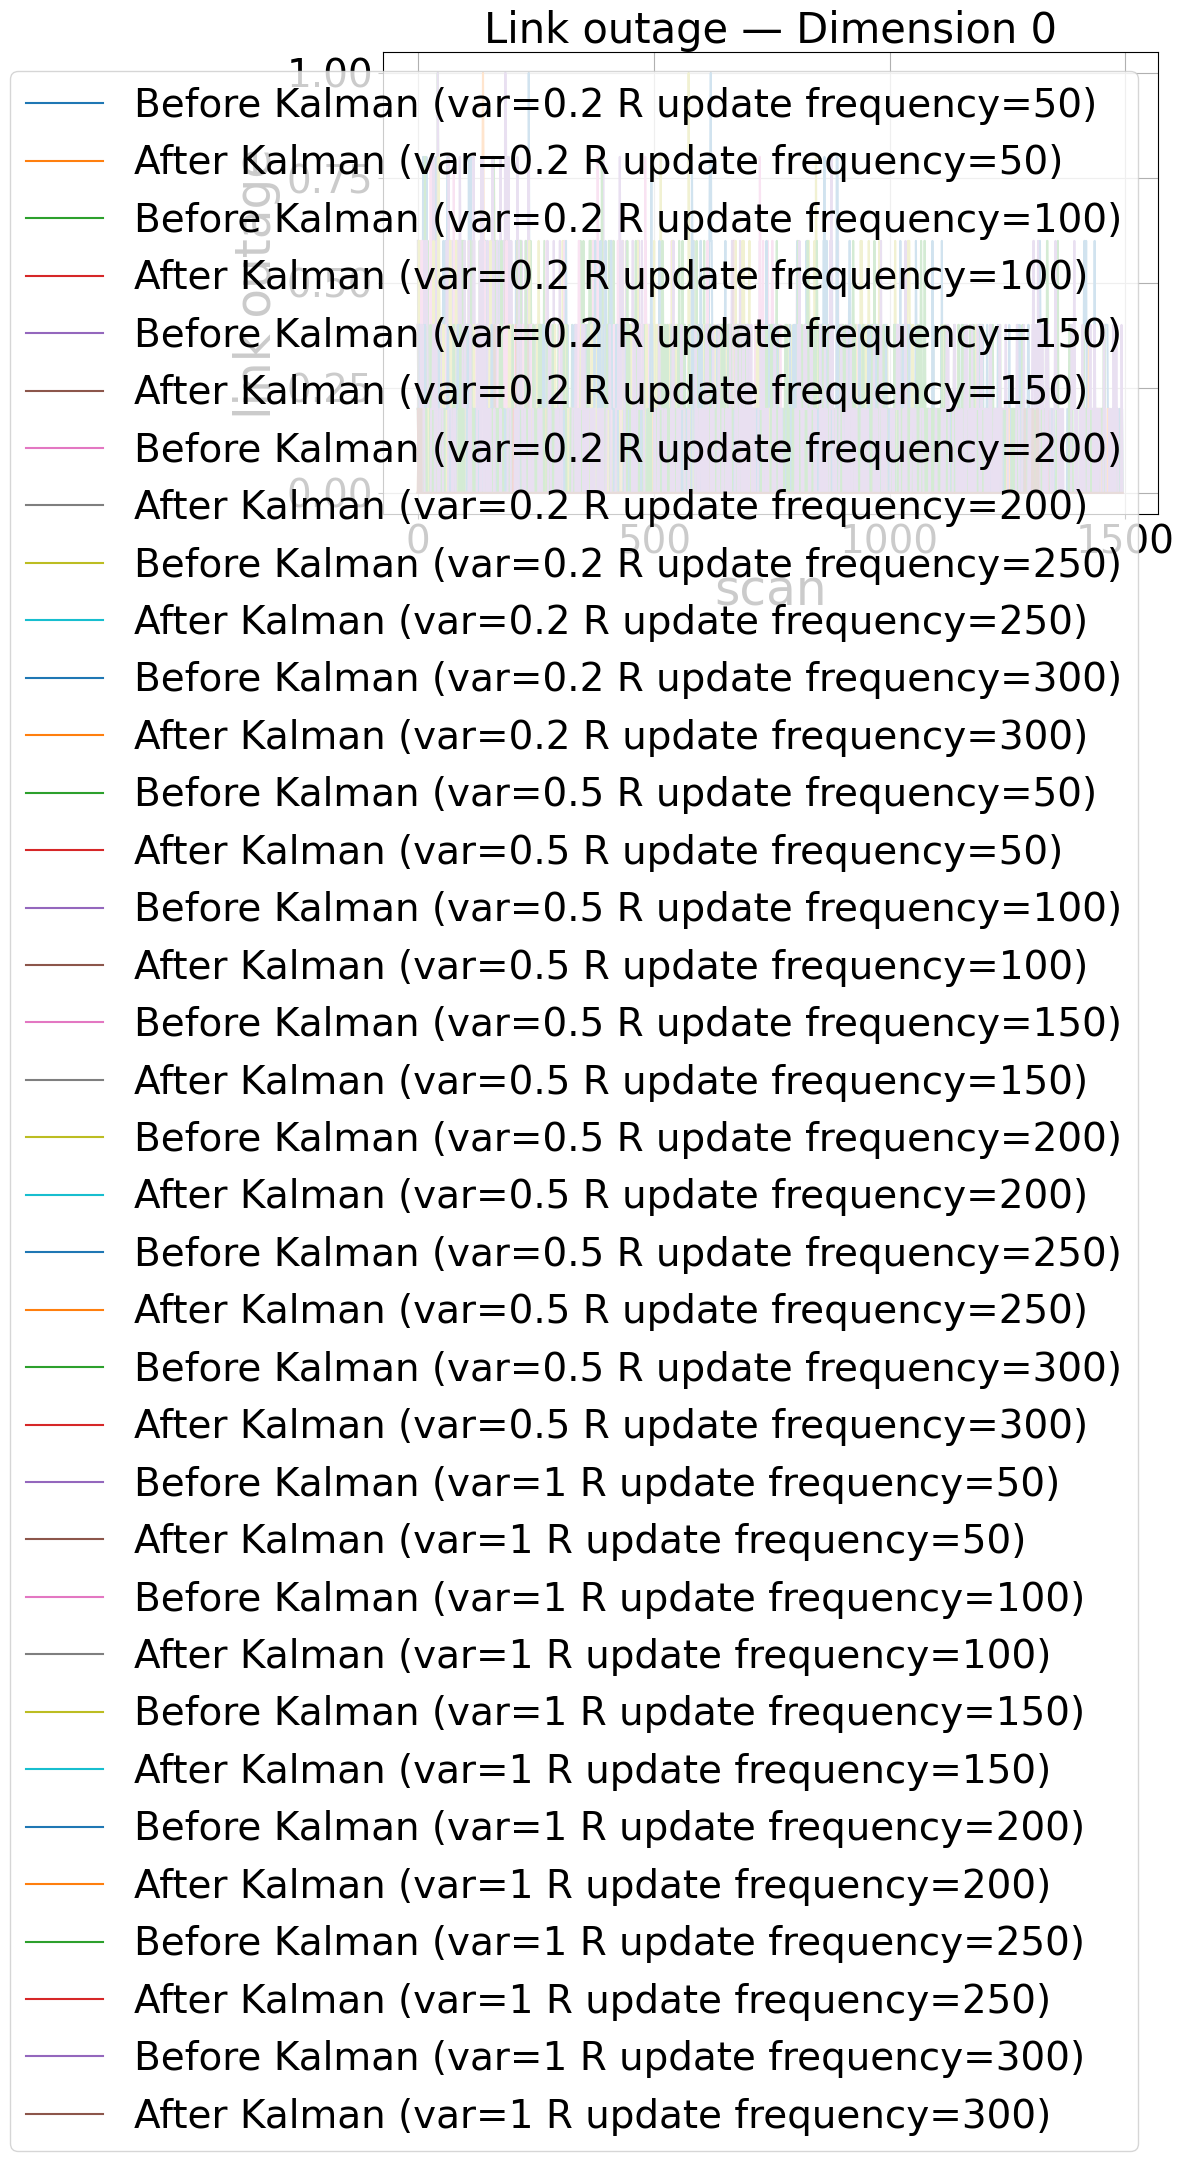

DEBUG: Checking indices idx=0, dim=1
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=1, dim=1
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=2, dim=1
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=3, dim=1
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=4, dim=1
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=5, dim=1
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=6, dim=1
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=7, dim=1
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=8, dim=1
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=9, dim=1
DEBUG: Type of link_outage_vs_sweep[0] is <class 'list'>
DEBUG: Checking indices idx=10, dim=1
DEBUG: Type of link_ou

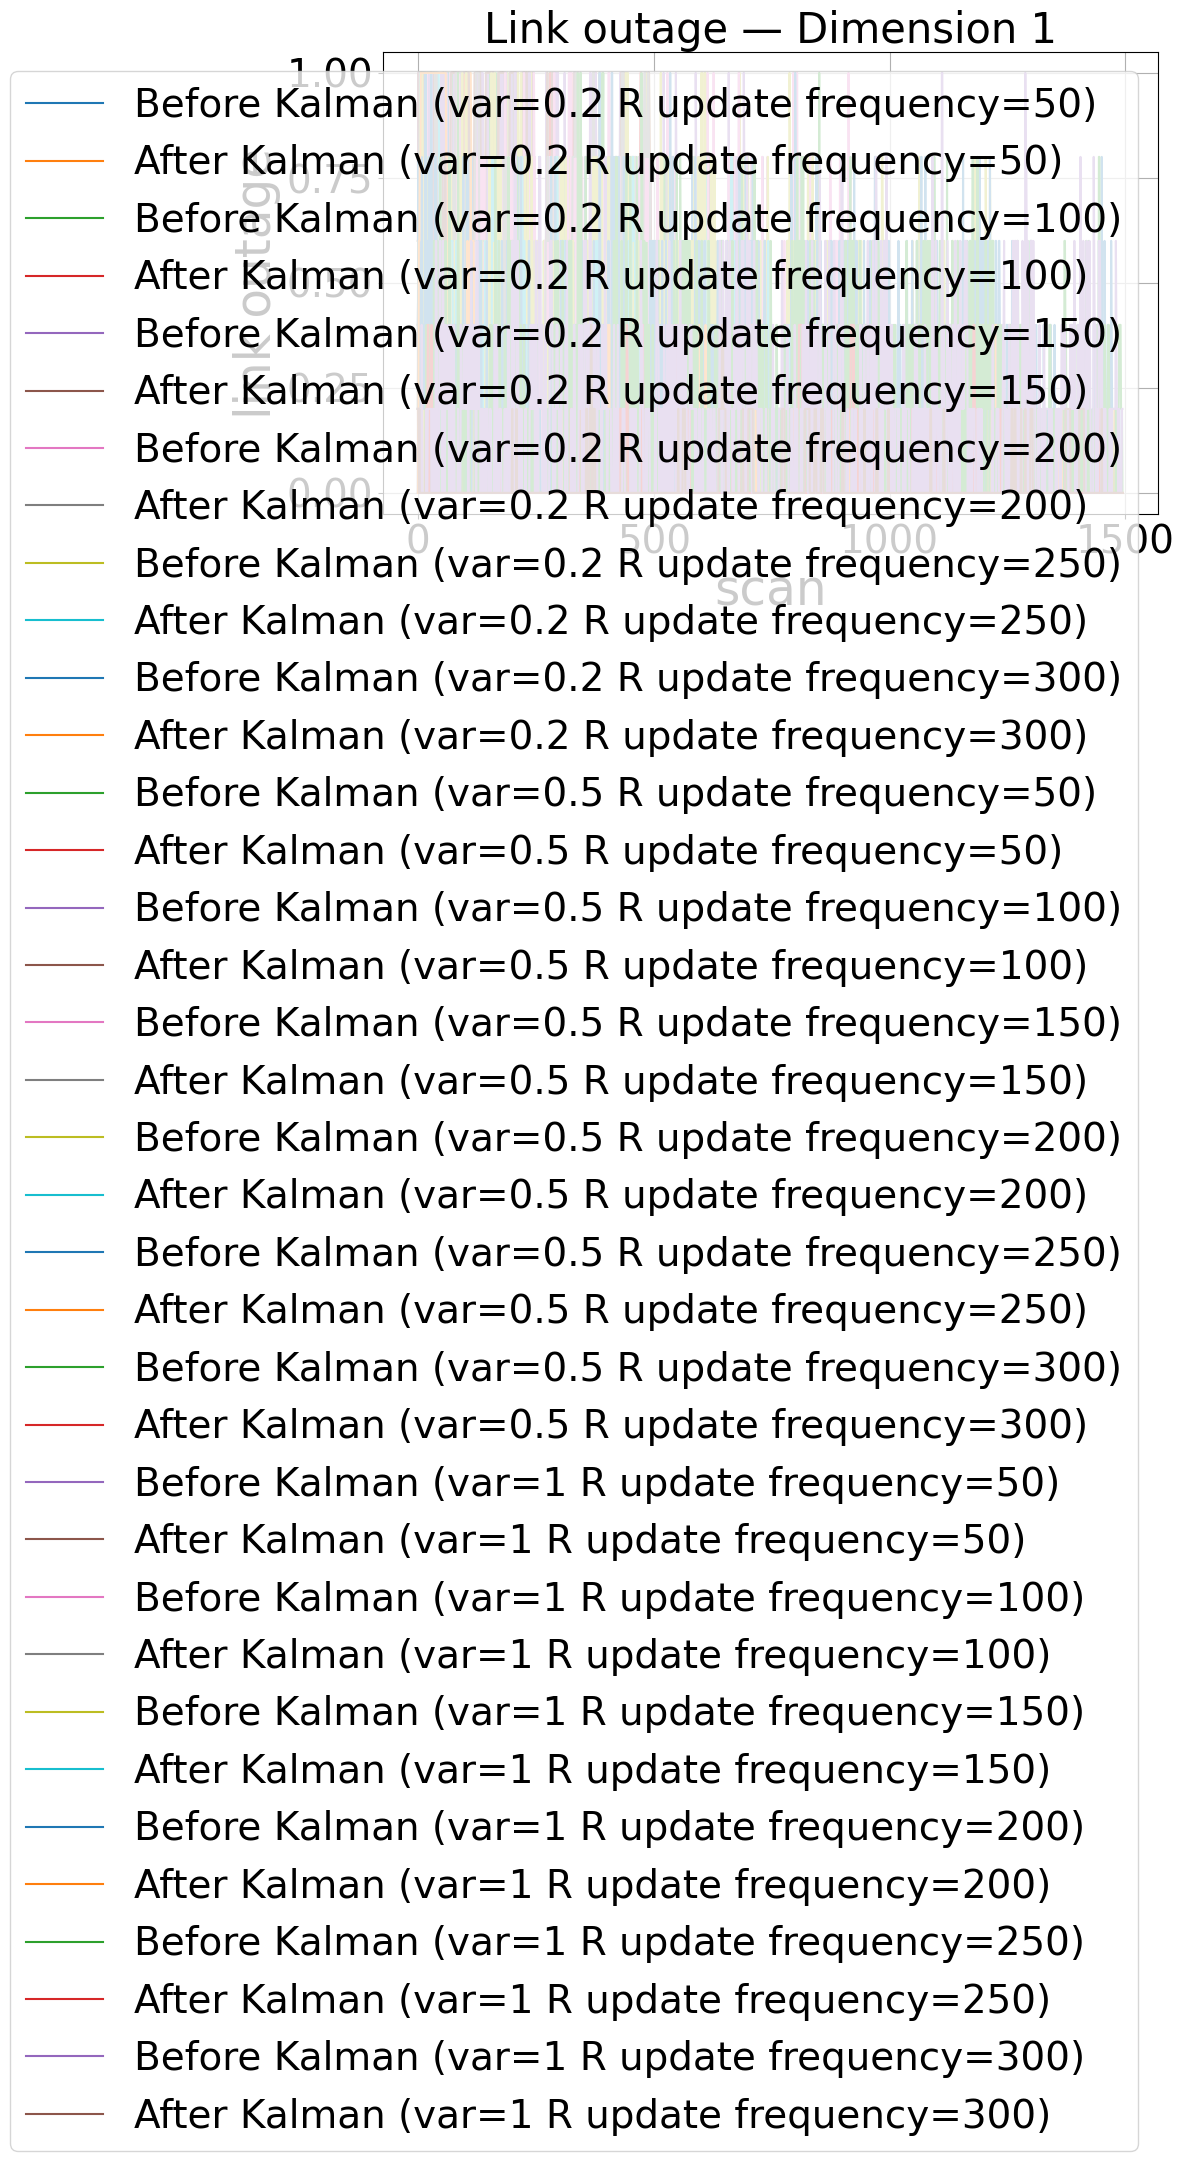

Data exported successfully to: /content/Simulation/LinkOutage/R update frequency_dim0_0.30444257426571836.mat
Total configurations: 18
Number of measurement variances: 3
Number of X parameters: 6
Data exported successfully to: /content/Simulation/LinkOutage/R update frequency_dim1_0.30444257426571836.mat
Total configurations: 18
Number of measurement variances: 3
Number of X parameters: 6


/tmp/ipython-input-1024005833.py:542: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


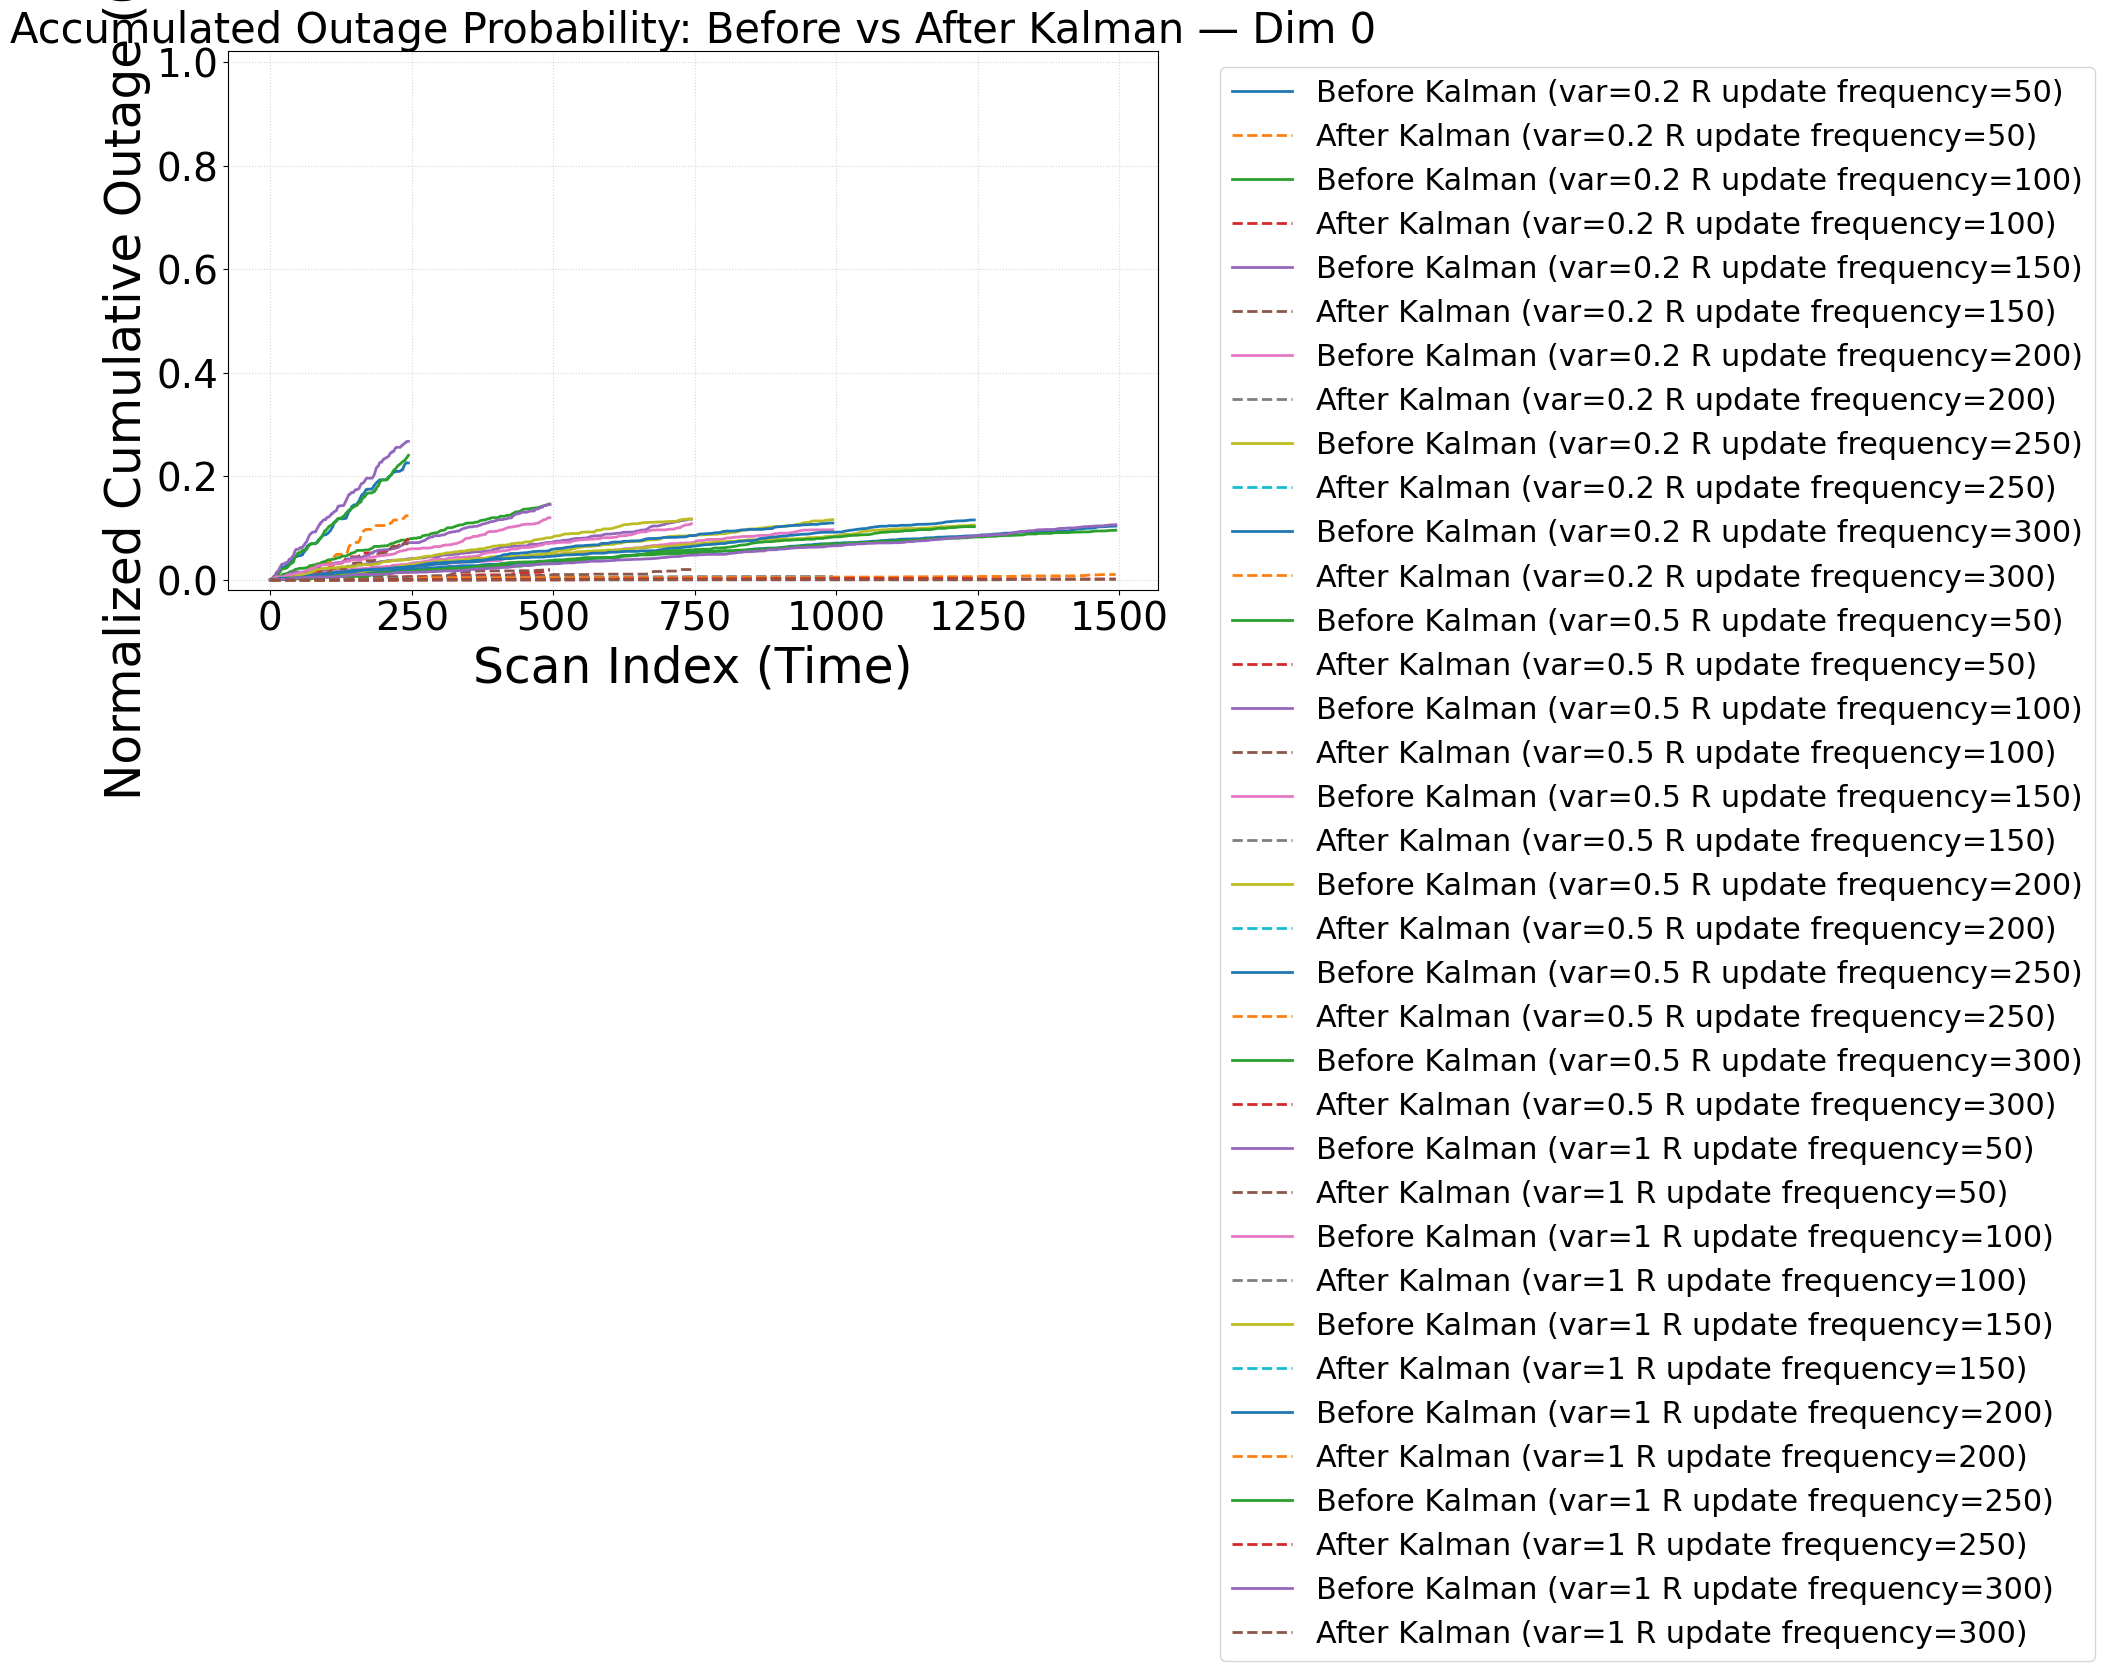

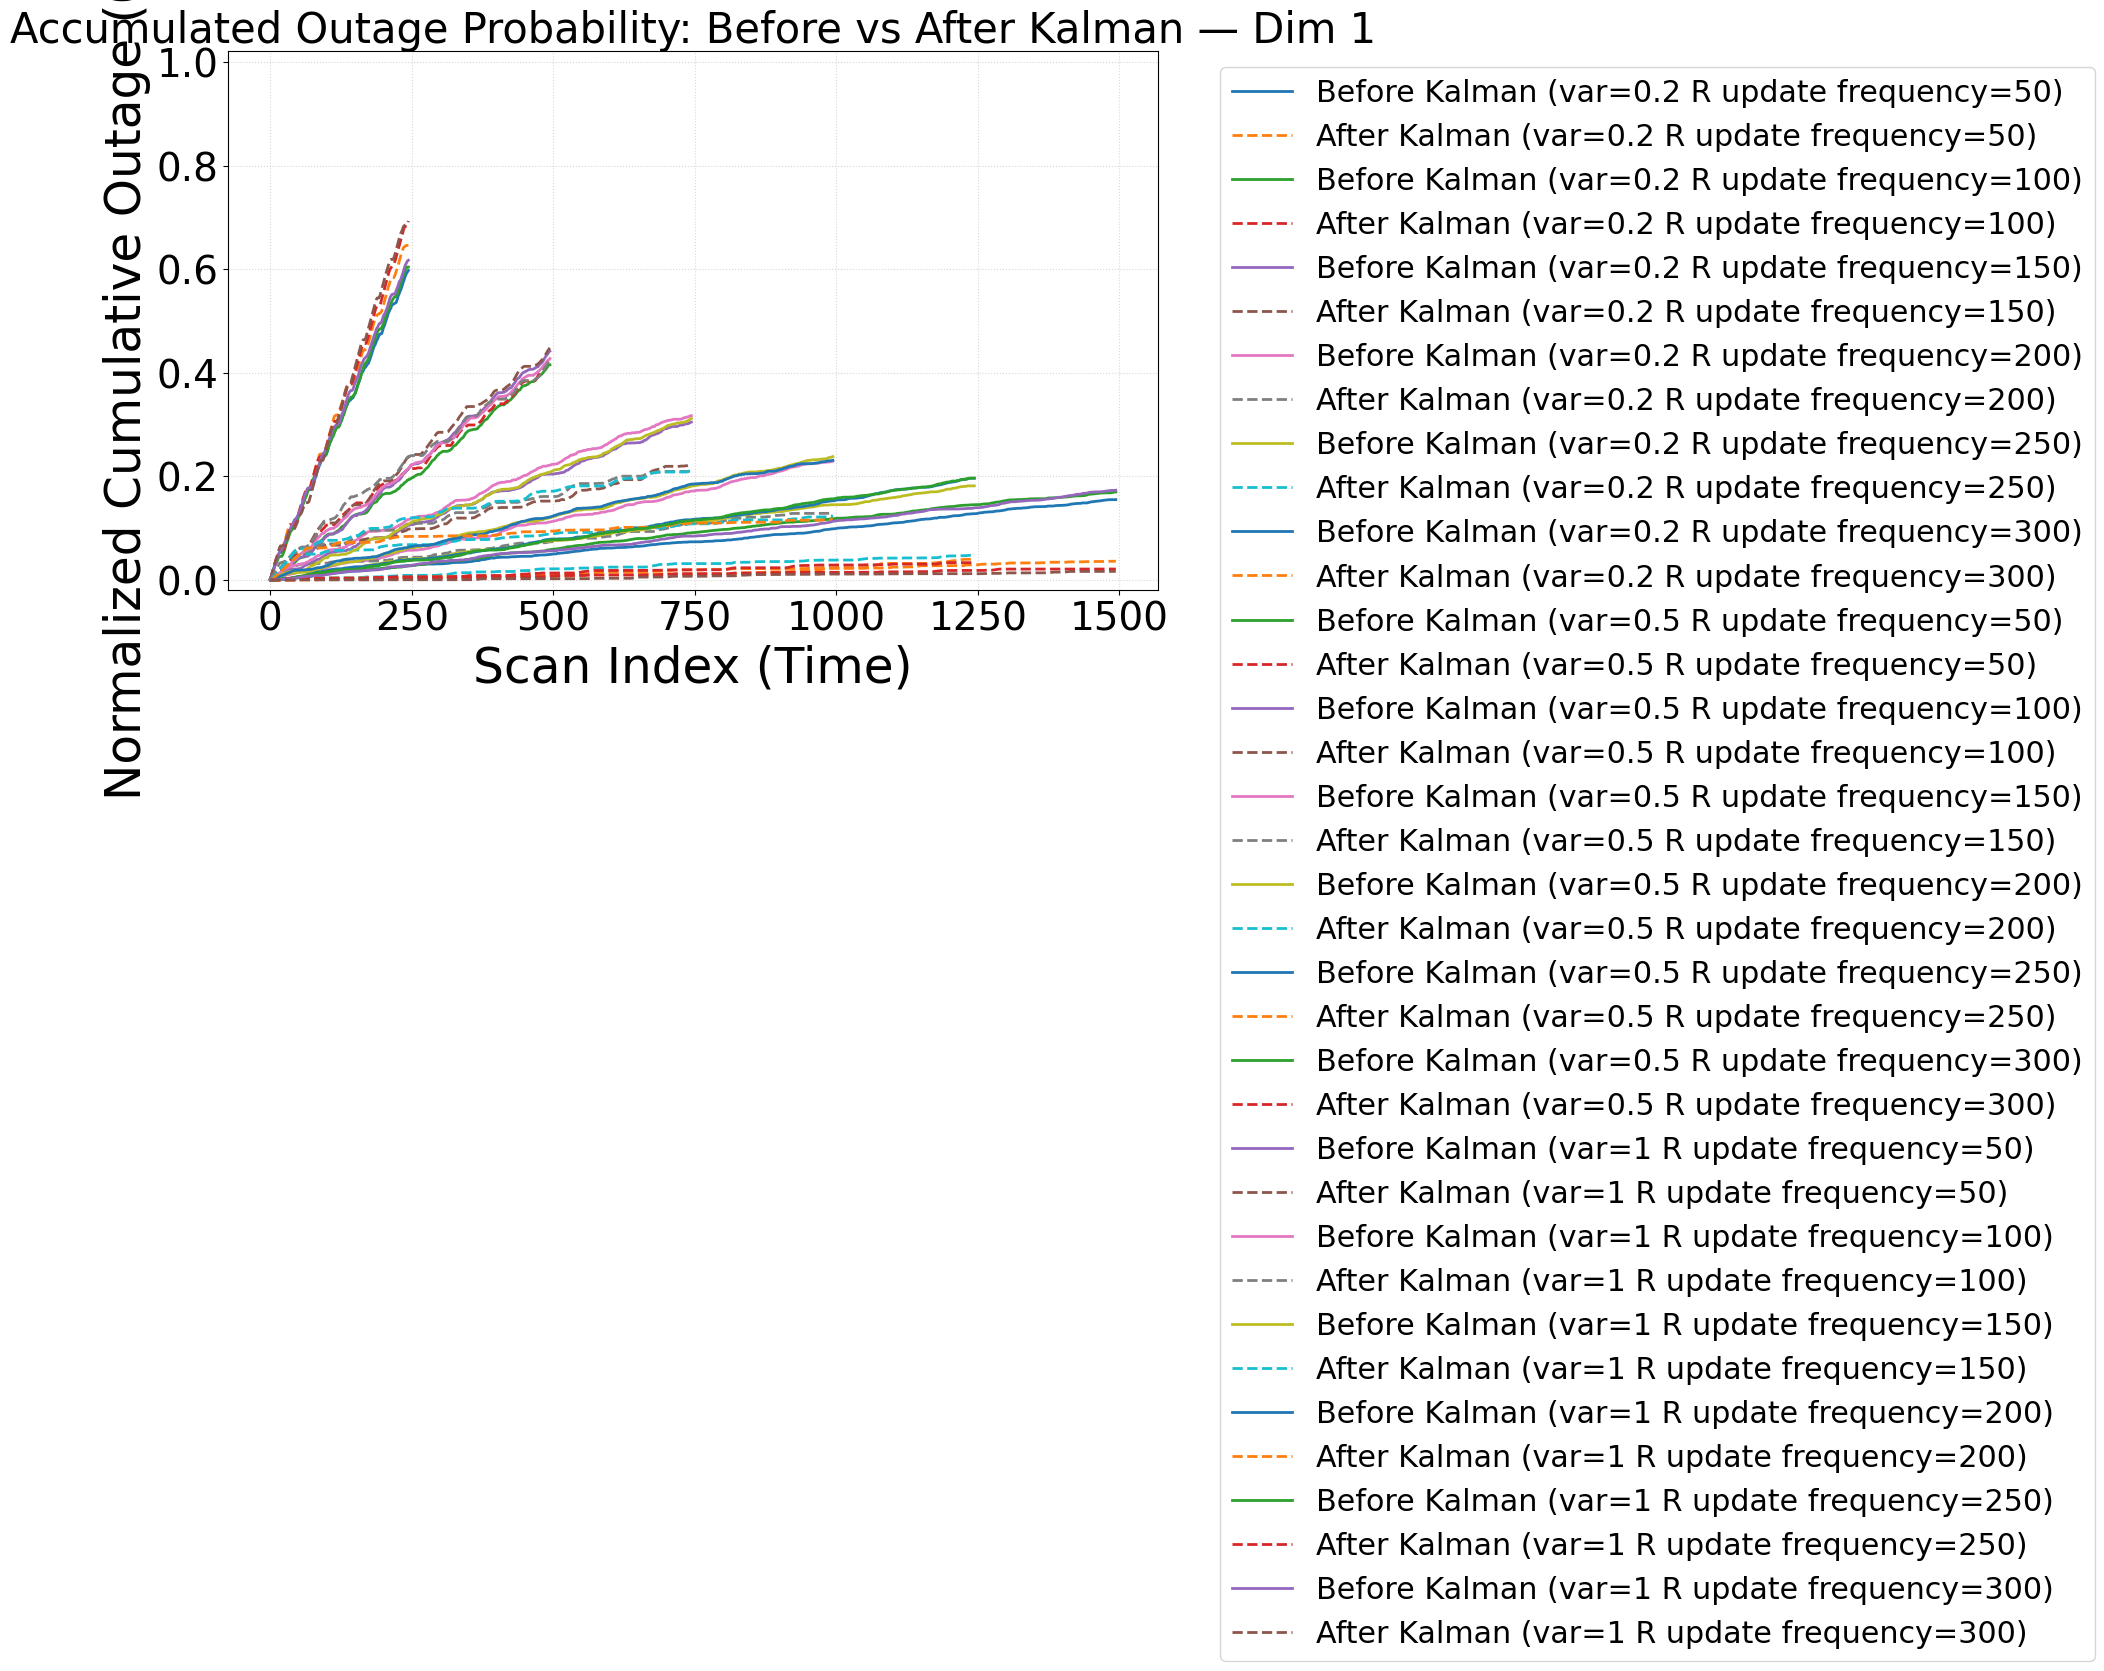

In [68]:
from scipy.linalg import dft

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Simulation parameters
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ========== Model parameters ==========

# Comunication parameters
rf_freq = 28e9
wavelength = 3e8 / rf_freq
bw = 200e6

#Physical system parameters
sample_freq = 2e9
d = wavelength / 2
number_of_dimensions= 2  #it will be or 1-D or 2-D
NumberOfbitsForPhaseShifter=8
ant_per_sub_array = 6
num_rf = 6
num_rf_vec = [6, 5, 4, 3, 2, 1]

#simulation time
duration_time = 5
#R
samples_for_R_calc_vec= [59, 60, 62, 63,65,70]
samples_for_R_calc=80
R_creating_freq_vector = [50, 100, 150, 200, 250, 300] #[50, 70, 90, 100, 110, 130, 150, 170]
R_creating_freq=80

#AngleResolution
angle_res=0.3
angle_res_vec= np.linspace(0.1, 1.2, 12).tolist()

#SNR
snr_vector = [2, 10]#[1, 2, 5, 10, 20]
snr=2

#Pole
swing_amplitude_factor = 1
average_wind_speed = 13
average_wind_speed_vec = [1, 5, 8, 10, 13, 16, 20, 50]

#Kalman filter params
measurments_var_vec=[0.2, 0.5, 1]

#for rmse Ploting
number_of_repeats_for_avarage = 5
rmse_vs_sweep= [[], []] # [ rmse_before_kalman, rmse_after_kalman ]

#LinkOutage
theta_max= np.rad2deg(0.3578 * np.arcsin(0.891/(60)))  # As there are 180 elements in the huge array
link_outage_vs_sweep =[[], []] # [ link_outage_before_kalman[[dim1],[dim2]], link_outage_after_kalman[[dim1],[dim2]] ]
# ========== Features enable ==========
#for the system functiunalty
random_phase_en = True # If false, use identity matrix that is collected in steps
applyAdaptiveKalman = True

plot_the_Pole = False # plot the pole movement
plot_the_simulation=False # plot the simulation
plot_the_algorithm_preformnce_of_Kalman=False #plot the compertion between the cohernce time and the H-MUSIC time
plot_the_rmse_vs_X=False
state_variance_plot =([True,True], #[plot position, plot position variance]
                      [True,True], #[plot angle velocity, plot angle velocity variance]
                      [True,True])  #[plot omega, plot omega variance]
plot_the_link_outage=True

rmse_vs_R_Creation_en=False
rmse_vs_R_Frequency_en = True
rmse_vs_ang_res_en = False
rmse_vs_SNR_en=False
# rmse_vs_Number_of_Element_en = False
rmse_vs_Number_of_subArries = False
rmse_vs_wind_speed_en = False

# ========== configurations for simulations ==========
plot_configs = {
    "rmse_vs_R_Creation_en": {
        "enabled": rmse_vs_R_Creation_en,
        "param_name": "samples_for_R_calc",
        "X": samples_for_R_calc_vec,
        "Title": ["$\\theta_d(t)$", "$\\theta_c(t)$"],
        "Xlabel": "number of samples for creating R",
        "log": False
    },

    "rmse_vs_R_Frequency_en": {
        "enabled": rmse_vs_R_Frequency_en,
        "param_name": "R_creating_freq",
        "X": R_creating_freq_vector,
        "Title": ["$\\theta_d(t)$", "$\\theta_c(t)$"],
        "Xlabel": "R update frequency",
        "log": False
    },

    "rmse_vs_ang_res_en": {
        "enabled": rmse_vs_ang_res_en,
        "param_name": "angle_res",
        "X": angle_res_vec,
        "Title": ["$\\theta_d(t)$", "$\\theta_c(t)$"],
        "Xlabel": "angle search resolution",
        "log": False
    },

    "rmse_vs_SNR_en": {
        "enabled": rmse_vs_SNR_en,
        "param_name": "snr",
        "X": snr_vector,
        "Title": ["$\\theta_d(t)$", "$\\theta_c(t)$"],
        "Xlabel": "SNR",
        "log": False
    },

    "rmse_vs_Number_of_SubArries": {
        "enabled": rmse_vs_Number_of_subArries,
        "param_name": "num_rf",
        "X": num_rf_vec,
        "Title": ["$\\theta_d(t)$", "$\\theta_c(t)$"],
        "Xlabel": "number of subarrays",
        "log": False
    },

    "rmse_vs_wind_speed_en": {
        "enabled": rmse_vs_wind_speed_en,
        "param_name": "average_wind_speed",
        "X": average_wind_speed_vec,
        "Title": ["$\\theta_d(t)$", "$\\theta_c(t)$"],
        "Xlabel": "pole average_wind_speed",
        "log": False
    }
}


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Simulation decleration
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cutoff = bw / sample_freq
taps = firwin(numtaps=101, cutoff=cutoff, window="hamming")

# Find the first enabled configuration
cfg = next((c for c in plot_configs.values() if c["enabled"]), None)
if cfg is None:
  print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
  print("No sweep is enabled. Nothing to run.")
  print("XxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXxXx")
  exit()

param_name = cfg["param_name"]
param_vec  = cfg["X"]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Start the loop
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for measurment_var in tqdm(measurments_var_vec, desc="measurment_var sweep",position=0):
  rmse_before_for_all_param_values = []
  rmse_after_for_all_param_values  = []
  #========== resting the Link outage vector============
  for param in tqdm(param_vec, desc=f"{param_name} sweep",position=1):
    # Assign the swept variable
    if param_name == "samples_for_R_calc":
        samples_for_R_calc = param
    elif param_name == "R_creating_freq":
        R_creating_freq = param
    elif param_name == "angle_res":
        angle_res = param
    elif param_name == "snr":
        snr = param
    elif param_name == "num_rf":
        num_rf = param
        ant_per_sub_array = 36 // num_rf
    elif param_name == "average_wind_speed":
        average_wind_speed = param
    rmse_before_vec_mean = None
    rmse_after_vec_mean = None
    link_outage_before_kalman_vec_mean = None
    link_outage_after_kalman_vec_mean = None
    for i in range(number_of_repeats_for_avarage):
      # ========== system decleration ==========

      TimeFramsPerAngle=ant_per_sub_array
      WrfQueue = deque(maxlen=TimeFramsPerAngle)
      RecievedSamplesQueue_vec = []
      for i in range(number_of_dimensions):
        RecievedSamplesQueue_vec.append(deque(maxlen=TimeFramsPerAngle))

      doa_angles_without_kalman_vec= np.arange(-5, 5, angle_res)
      doa_angles_with_kalman_vec = [np.copy(doa_angles_without_kalman_vec) for _ in range(2)]

      R_Calculator = RCalculator(num_rf * ant_per_sub_array, "avarage")
      hpa = HybridPhasedArray(ant_per_sub_array, num_rf, d, wavelength,NumberOfbitsForPhaseShifter)

      Kalman_vec = []
      for i in range(number_of_dimensions):
        Kalman_vec.append(
            EKF(init_angle=0,
            init_angularVelocity=0.05,
            init_Omega=8,
            init_var=[20, 20, 2],
            measurments_var=measurment_var,
            proccess_variance=[0.01,0.01 ,0.01],
            dt=1/R_creating_freq    )
            )

      hmusic_without_kalman = HMusicDoa(
          ant_num=ant_per_sub_array,
          rf_num=num_rf,
          dist_between_ant=d,
          wave_lambda=wavelength,
          weights_matrix=None
          )

      hmusic_with_kalman= HMusicDoa(
          ant_num=ant_per_sub_array,
          rf_num=num_rf,
          dist_between_ant=d,
          wave_lambda=wavelength,
          weights_matrix=None
          )

      # ========== kalman states and results vectors ==========

      est_angles_before_kalman_vec = [[], []]
      est_angles_after_kalman_vec = [[], []]
      est_angles_velocities_kalman_vec=[[], []]
      est_omega_after_kalman_vec=[[], []]
      est_var_angles_after_kalman_vec=[[], []]
      est_var_angles_velocity_after_kalman_vec=[[], []]
      est_var_omega_after_kalman_vec=[[], []]
      rmse_before_vec = []
      rmse_after_vec = []
      link_outage_before_kalman_vec= [[],[]]
      link_outage_after_kalman_vec= [[],[]]

      cnt = 0

      # ========== pole sway movement generation ==========

      pole = SwingingPole(T=duration_time, Fs=R_creating_freq, u_avg=average_wind_speed, seed=0)
      theta_d, theta_c, Ld_freq, Lc_freq, velocity_d, velocity_c = pole.run() * swing_amplitude_factor
      pole_movement_vec = [theta_d, theta_c, Ld_freq, Lc_freq, velocity_d, velocity_c]
      if(plot_the_Pole):
        ExportPoleSway(theta_d,theta_c)
        pole.plot_results()


      # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      # Main algorithm loop
      # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

      for theta_idx in tqdm(range(len(pole_movement_vec[0])),
                            desc="theta_idx loop",
                            position=2, leave=False):

    # ========== base band signal generation  ==========

          noise = np.random.normal(0, 1, samples_for_R_calc) + \
                  1j * np.random.normal(0, 1, samples_for_R_calc)
          signal0 = lfilter(taps, 1.0, noise)

    # ========== W_rf generation  ==========

          Wrf_Frame = np.zeros((num_rf, num_rf * ant_per_sub_array), dtype=complex)
          Wrf_Frame_noisy = np.zeros((num_rf, num_rf * ant_per_sub_array), dtype=complex)
          if random_phase_en:
            for i in range(num_rf):
                random_noisy_phases, random_phases = hpa.GeneratePhase()
                Wrf_Frame[i, i * ant_per_sub_array:(i + 1) * ant_per_sub_array] = random_phases
                Wrf_Frame_noisy[i, i * ant_per_sub_array:(i + 1) * ant_per_sub_array] = random_noisy_phases
          else:
              cnt_mod = cnt % num_rf
              Wrf_Frame = dft(num_rf * ant_per_sub_array)[cnt_mod * num_rf: (cnt_mod+1) * num_rf]
              Wrf_Frame_noisy=Wrf_Frame
              cnt += 1
          WrfQueue.append(Wrf_Frame)
          hpa.Config(Wrf_Frame_noisy)


    # ========== Recieve signal and uncorelted noise  ==========

          received_matrix_vec = []
          for i in range(number_of_dimensions):
            received_matrix_vec.append(
              hpa.GetSamples(signal0, pole_movement_vec[i][theta_idx])
            )

          noise_power = np.sqrt(2) / np.sqrt(snr)
          for i in range(number_of_dimensions):
            received_matrix_vec[i] += noise_power * (
                np.random.randn(*received_matrix_vec[0].shape) +
                1j * np.random.randn(*received_matrix_vec[0].shape)
            )

          for i in range(number_of_dimensions):
            RecievedSamplesQueue_vec[i].append(received_matrix_vec[i])
          if(len(RecievedSamplesQueue_vec[0]) < TimeFramsPerAngle):
            continue

    # ========== Create autocoreltion matrix ==========

          Wrf = np.vstack(WrfQueue)
          hmusic_without_kalman.UpdateWRF(Wrf)
          hmusic_with_kalman.UpdateWRF(Wrf)

          received_matrix_Over_Time_vec = []
          for j in range(number_of_dimensions):
            received_matrix_Over_Time_vec.append(np.zeros((num_rf * ant_per_sub_array, ant_per_sub_array * samples_for_R_calc),dtype=complex))
            for i in range(ant_per_sub_array):
              received_matrix_Over_Time_vec[j][i*num_rf:(i+1)*num_rf, i*samples_for_R_calc:(i+1)*samples_for_R_calc] = RecievedSamplesQueue_vec[j][i]

          R_vec = []
          for i in range(2):
            R_vec.append(R_Calculator.GetSamples(received_matrix_Over_Time_vec[i]))

    # ========== Apply H-MUSIC without kalman - doa angles range is fixed ==========

          signal_count = 1
          for i in range(number_of_dimensions):
            angles, power_db = hmusic_without_kalman.GetSamples(
                R_vec[i],i, scanAnglesDeg=doa_angles_without_kalman_vec, signal_count=signal_count,
            )
            est_angle = angles[np.argmax(power_db)]
            est_angles_before_kalman_vec[i].append(est_angle)

    # ========== Apply H-MUSIC with kalman - doa angles range is determent by the kalman estimations ==========

          for i in range(number_of_dimensions):
            angles, power_db = hmusic_with_kalman.GetSamples(
                R_vec[i],i, scanAnglesDeg=doa_angles_with_kalman_vec[i], signal_count=1,
            )
            est_angle = angles[np.argmax(power_db)]
            if(applyAdaptiveKalman==True):
              state_after_Kalman, var_after_Kalman = Kalman_vec[i].GetSampels(est_angle)
              est_angles_after_kalman_vec[i].append(state_after_Kalman[0])
              est_angles_velocities_kalman_vec[i].append(state_after_Kalman[1])
              est_omega_after_kalman_vec[i].append(state_after_Kalman[2])
              est_var_angles_after_kalman_vec[i].append(var_after_Kalman[0])
              est_var_angles_velocity_after_kalman_vec[i].append(var_after_Kalman[1])
              est_var_omega_after_kalman_vec[i].append(var_after_Kalman[2])
              sigma = np.sqrt(Kalman_vec[i].mP_predict[0,0])
              center = Kalman_vec[i].mX_predict[0,0]
              if sigma > 45:
                sigma = 45  # To avoide a case where the uncertaty keep growing uncontrolably
              doa_angles_with_kalman_vec[i] = np.arange(center - 2*sigma,
                                          center+ 2*sigma,
                                          angle_res)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # End of the Main loop- Parse results
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

      for i in range(number_of_dimensions):
        true_angles = pole_movement_vec[i][ant_per_sub_array - 1:]
        est_angles_before_kalman  = est_angles_before_kalman_vec[i][:len(true_angles)]
        rmse_before_vec.append(root_mean_squared_error(true_angles, est_angles_before_kalman))
        if(applyAdaptiveKalman==False):
          state_after_Kalman, var_after_Kalman= Kalman_vec[i].GetSampels(est_angles_before_kalman_vec[i])

          est_angles_after_kalman_vec[i]=(state_after_Kalman[:, 0])
          est_angles_velocities_kalman_vec[i]=(state_after_Kalman[:,1])
          est_omega_after_kalman_vec[i]=(state_after_Kalman[:,2])

          est_var_angles_after_kalman_vec[i]=(var_after_Kalman[:,0])
          est_var_angles_velocity_after_kalman_vec[i]=(var_after_Kalman[:,1])
          est_var_omega_after_kalman_vec[i]=(var_after_Kalman[:,2])

        est_angles_after_kalman_vec[i]= np.squeeze(np.array(est_angles_after_kalman_vec[i]))
        true_angles = pole_movement_vec[i][ant_per_sub_array - 1:]
        est_angles_after_kalman  = est_angles_after_kalman_vec[i][:len(true_angles)]
        rmse_after_vec.append(root_mean_squared_error(true_angles, est_angles_after_kalman))
        #build the link outage vec
        if(plot_the_link_outage):
          for t in range(len(true_angles)):
            delta_theta_befor_kalman= np.abs(true_angles[t] - est_angles_before_kalman[t])
            delta_theta_after_kalman= np.abs(true_angles[t] - est_angles_after_kalman[t])
            link_outage_before_kalman_vec[i].append(0 if delta_theta_befor_kalman < theta_max else 1)
            link_outage_after_kalman_vec[i].append(0 if delta_theta_after_kalman < theta_max else 1)

    # ========== Calculate uncertety sleeves ==========

      ciPosition=1.96 * np.sqrt(est_var_angles_after_kalman_vec)
      ciVelocity= 1.96 * np.sqrt(est_var_angles_velocity_after_kalman_vec)
      ciOmega= 1.96 * np.sqrt(est_var_omega_after_kalman_vec)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Plot results
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      if(plot_the_simulation):
        Titel_for_simulation= ["$\\theta_d(t)$", "$\\theta_c(t)$",
                r"$\dot{\theta}_{d}(t)$",r"$\dot{\theta}_{c}(t)$",
                "$\\omega_d(t)$","$\\omega_c(t)$"]
        PlotSimulation(state_variance_plot,
        number_of_dimensions,
        Titel_for_simulation,
        pole_movement_vec,
        est_angles_before_kalman_vec,
        est_angles_after_kalman_vec,
        est_angles_velocities_kalman_vec,
        est_omega_after_kalman_vec,
        ciPosition,
        ciVelocity,
        ciOmega,
        rmse_before_vec,
        rmse_after_vec,
        ant_per_sub_array)

      if(plot_the_algorithm_preformnce_of_Kalman):
        Title_for_complexity=[f"$\\Delta\\theta_d={angle_res}$",
                              f"$\\Delta\\theta_c={angle_res}$"]
        PlotNumberOfMultiplications(hmusic_without_kalman,
                                    hmusic_with_kalman,
                                    Kalman_vec,
                                    number_of_dimensions,
                                    Title_for_complexity)
        PlotMultiplacationTimePerSample(samples_for_R_calc,
                                    hmusic_without_kalman,
                                    hmusic_with_kalman,
                                    Kalman_vec,
                                    number_of_dimensions)
        PlotMultiplacationTimePerSample_Delta(samples_for_R_calc,
                                    hmusic_with_kalman,
                                    Kalman_vec,
                                    number_of_dimensions)
      if rmse_before_vec_mean is None:
        rmse_before_vec_mean = [[rmse_before_vec[0]],[rmse_before_vec[1]]]
        rmse_after_vec_mean = [[rmse_after_vec[0]],[rmse_after_vec[1]]]
      else:
        for i in range(len(rmse_before_vec_mean)):
          rmse_before_vec_mean[i].append(rmse_before_vec[i])
          rmse_after_vec_mean[i].append(rmse_after_vec[i])
      if link_outage_before_kalman_vec_mean is None:
          link_outage_before_kalman_vec_mean = np.array(link_outage_before_kalman_vec, dtype=float)
          link_outage_after_kalman_vec_mean = np.array(link_outage_after_kalman_vec, dtype=float)
      else:
          link_outage_before_kalman_vec_mean += np.array(link_outage_before_kalman_vec, dtype=float)
          link_outage_after_kalman_vec_mean += np.array(link_outage_after_kalman_vec, dtype=float)

    # End of mean loop
    for i in range(number_of_dimensions):
     rmse_before_vec_mean[i] = np.median(rmse_before_vec_mean[i])
     rmse_after_vec_mean[i] = np.median(rmse_after_vec_mean[i])
     link_outage_before_kalman_vec_mean[i] = link_outage_before_kalman_vec_mean[i] / number_of_repeats_for_avarage
     link_outage_after_kalman_vec_mean[i] = link_outage_after_kalman_vec_mean[i] / number_of_repeats_for_avarage
  # End of param loop
    if (plot_the_rmse_vs_X):
        rmse_before_for_all_param_values.append(rmse_before_vec_mean)
        rmse_after_for_all_param_values.append(rmse_after_vec_mean)
    if(plot_the_link_outage):
      link_outage_vs_sweep[0].append(link_outage_before_kalman_vec_mean.tolist())
      link_outage_vs_sweep[1].append(link_outage_after_kalman_vec_mean.tolist())

  # End of parameter sweep loop
  rmse_vs_sweep[0].append(rmse_before_for_all_param_values)
  rmse_vs_sweep[1].append(rmse_after_for_all_param_values)

# End of both loops

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# plots
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
if cfg is not None:
    #extract the properties
      X_vec   = cfg["X"]
      Titles  = cfg["Title"]
      Xlabel  = cfg["Xlabel"]
      log_display= cfg["log"]

#simulation analysis
if(plot_the_rmse_vs_X):

      # Plot rmse vs X
      Plotrmse_Vs_X(
          X_vec,
          rmse_vs_sweep,
          measurments_var_vec,
          X_lable=Xlabel,
          log=log_display
      )

      # Plot Delta
      Plotrmse_Vs_X_Delta(
          X_vec,
          rmse_vs_sweep,
          measurments_var_vec,
          X_lable=Xlabel,
          log=log_display
      )

if(plot_the_link_outage):
  X_vec   = cfg["X"]
  paramterType=cfg["Xlabel"]
  # plot link_outage_simple
  PlotLinkOutage(X_vec,link_outage_vs_sweep, measurments_var_vec, paramterType)
  # plot link outage accumualte
  PlotLinkOutageAccumulate(X_vec,link_outage_vs_sweep, measurments_var_vec, paramterType)

